## 5.3、5.4  PyTorch实现DQN

In [1]:
# import必要的包
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gym


ModuleNotFoundError: No module named 'gym'

In [2]:
# 声明动画的绘图函数
# 参考URL http://nbviewer.jupyter.org/github/patrickmineault
# /xcorr-notebooks/blob/master/Render%20OpenAI%20gym%20as%20GIF.ipynb
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display


def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0),
               dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames),
                                   interval=50)

    anim.save('movie_cartpole_DQN.mp4')  # 动画保存的文件名
    display(display_animation(anim, default_mode='loop'))
    

In [1]:
# 此代码使用namedtuple
# 您可以使用namedtuple将值与字段名称存储为一对。
# 然后，您可以按字段名称访问值，这很方便。
# https://docs.python.jp/3/library/collections.html#collections.namedtuple
# 以下是用法示例

from collections import namedtuple

Tr = namedtuple('tr', ('name_a', 'value_b'))
Tr_object = Tr('名称为A', 100)

print(Tr_object)  # 输出：tr（name_a ='名称为 A'，value_b = 100）
print(Tr_object.value_b)  # 输出：100


tr(name_a='名称为A', value_b=100)
100


In [4]:
# 生成namedtuple
from collections import namedtuple

Transition = namedtuple(
    'Transition', ('state', 'action', 'next_state', 'reward'))


In [5]:
# 常量的设定
ENV = 'CartPole-v0'  # 要使用的任务名称
GAMMA = 0.99  # 时间折扣率
MAX_STEPS = 200  # 1此试验中的step数
NUM_EPISODES = 500  # 最大尝试次数


### 定义存储经验的内存类
为了实现小批量学习，我们定义了内存类ReplayMemory来存储经验数据。ReplayMemory准备了一个函数push，用于保存该步骤找那个的transition（作为经验）还包括一个随机选择transition的函数sample。它还定义函数len以返回当前存储的transition数。在内存类中，如果存储的transition数大于常量CAPACITY,则将索引返回到前面并覆盖旧内容。

In [6]:
# 定义用于存储经验的内存类


class ReplayMemory:

    def __init__(self, CAPACITY):
        self.capacity = CAPACITY  # 下面memory的最大长度
        self.memory = []  # 存储过往的经验
        self.index = 0  # 表示要保存的索引

    def push(self, state, action, state_next, reward):
        '''transition = (state, action, state_next, reward)保存在存储器中'''

        if len(self.memory) < self.capacity:
            self.memory.append(None)  # 内存未满时添加

        # 使用namedtuple对象Transition将值和字段名称保存为一对
        self.memory[self.index] = Transition(state, action, state_next, reward)

        self.index = (self.index + 1) % self.capacity  # 将保存的index移动一位

    def sample(self, batch_size):
        '''随机检索Batch_size大小的样本并返回'''
        return random.sample(self.memory, batch_size)

    def __len__(self):
        '''返回当前memory的长度'''
        return len(self.memory)


### 接下来实现Brain类，这是DQN的核心。
第三章的代码中解释的表格表示的Q学习中，Brain类有一个表，但这里有一个神经网络，使用函数replay和函数decision_action。函数replay从内存中获取小批量数据，学习神经网络连接参数，并更新Q函数。函数decision_action遵循 $\epsilon$-贪婪法，返回随机选取的动作或在当前状态下具有最高Q值的动作的索引index。

In [7]:
# 它是成为智能体的大脑的类，它执行DQN
# 将Q函数定义为深度学习网络

import random
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

BATCH_SIZE = 32
CAPACITY = 10000


class Brain:
    def __init__(self, num_states, num_actions):
        self.num_actions = num_actions  # 获取CartPole的两个动作（向左或向右）

        # 创建存储经验的对象
        self.memory = ReplayMemory(CAPACITY)

        # 建立神经网络
        self.model = nn.Sequential()
        self.model.add_module('fc1', nn.Linear(num_states, 32))
        self.model.add_module('relu1', nn.ReLU())
        self.model.add_module('fc2', nn.Linear(32, 32))
        self.model.add_module('relu2', nn.ReLU())
        self.model.add_module('fc3', nn.Linear(32, num_actions))

        print(self.model)  # 输出网络形状

        # 设置优化方法
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0001)

    def replay(self):
        '''通过Experience Replay学习神经网络的连接参数'''

        # -----------------------------------------
        # 1. 检查经验池的大小
        # -----------------------------------------
        # 1.1 当内存大小小于小批量数据时不执行任何操作
        if len(self.memory) < BATCH_SIZE:
            return

        # -----------------------------------------
        # 2. 创建小批量数据
        # -----------------------------------------
        # 2.1 从经验池中获取小批量数据
        transitions = self.memory.sample(BATCH_SIZE)

        # 2.2 将每个变量转换为与小批量数据对应的形式
        # 得到的transitions存储了一个BATCH_SIZE的（state,action,state_next,reward）
        #即（state,action,state_next,reward）×BATCH_SIZE
        #想把它变成小批量数据。换句话说
        #设为(state×BATCH_SIZE,action×BATCH_SIZE,state_next×BATCH_SIZE,reward×BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        # 2.3 将每个变量的元素转换为与小批量数据相对应的形式，并将其设置为变量，以便可以在网络中进行处理
        # 例如，对于state，形状为[torch.FloatTensor of size 1×4]
        # 将其转换为 torch.FloatTensor of size BATCH_SIZEx4 
        # 为状态，动作，奖励，非最终状态小批量创建变量
        # cat代表Concatenates（级联）
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                           if s is not None])

        # -----------------------------------------
        # 3. 求取Q（s_t,a_t）值作为监督信号
        # -----------------------------------------
        # 3.1 将网络切换到推理模式
        self.model.eval()

        # 3.2 求取网络输出的Q（s_t，a_t）
        # self.model(state_batch)输出左右两个Q值
        # [torch.FloatTensor of size BATCH_SIZEx2]になっている。
        # 为了求得与从此处执行的动作a_t对应的Q值，找到由action_batch执行的动作a_t是右还是左的index
        # 用gather获得相应的Q值。
        state_action_values = self.model(state_batch).gather(1, action_batch)

        # 3.3 求取max{Q(s_t+1, a)}値。但是，请注意以下状态

        # 创建一个索引掩码以检查cartpole是否未完成，且具有next_state
        non_final_mask = torch.ByteTensor(tuple(map(lambda s: s is not None,
                                                    batch.next_state)))
        # 首先全部设置为0
        next_state_values = torch.zeros(BATCH_SIZE)

        # 求取具有下一状态的index的最大Q值
        # 访问输出并通过max（1）查找列方向上的最大值[value，index]。
        # 并输出其Q值（index=0）
        # 用detach取出该值
        next_state_values[non_final_mask] = self.model(
            non_final_next_states).max(1)[0].detach()

        # 3.4 从Q公式中求取Q（s_t,a_t）值作为监督信息
        expected_state_action_values = reward_batch + GAMMA * next_state_values

        # -----------------------------------------
        # 4. 更新连接参数
        # -----------------------------------------
        # 4.1 将网络切换到训练模式
        self.model.train()

        # 4.2 计算损失函数（smooth_l1_loss是Huberloss）
        # expected_state_action_values的
        # size是[minbatch]，通过unsqueeze得到[minibatch x 1]
        loss = F.smooth_l1_loss(state_action_values,
                                expected_state_action_values.unsqueeze(1))

        # 4.3 更新联接参数
        self.optimizer.zero_grad()  # 重置渐变
        loss.backward()  # 计算反向传播
        self.optimizer.step()  # 更新连接参数

    def decide_action(self, state, episode):
        '''根据当前状态确定动作'''
        # 采用ε-greedy法逐步采用最佳动作
        epsilon = 0.5 * (1 / (episode + 1))

        if epsilon <= np.random.uniform(0, 1):
            self.model.eval()  # 将网络切换到推理模式
            with torch.no_grad():
                action = self.model(state).max(1)[1].view(1, 1)
            # 获取网络最大值的索引index= max(1)[1]
            # .view(1,1)将[torch.LongTensor of size 1]　转换为 size 1x1 大小

        else:
            # 随机返回0，1的动作
            action = torch.LongTensor(
                [[random.randrange(self.num_actions)]])  # 随机返回0，1的动作
            # action的形式为[torch.LongTensor of size 1x1]

        return action


上面代码中，函数replay执行了以下四个步骤
1. 检查经验池的大小
2. 创建小批量数据
3. 求取将成为监督信息的Q（s_t,a_t）值
4. 更新连接参数

In [8]:
# 这是一个在CartPole上运行的智能体类，它是带有杆的小车


class Agent:
    def __init__(self, num_states, num_actions):
        '''设置任务状态和动作数量'''
        self.brain = Brain(num_states, num_actions)  # 为智能体生成大脑来决定他们的动作

    def update_q_function(self):
        '''更新Q函数'''
        self.brain.replay()

    def get_action(self, state, episode):
        '''确定动作'''
        action = self.brain.decide_action(state, episode)
        return action

    def memorize(self, state, action, state_next, reward):
        '''将state, action, state_next, reward的内容保存在经验池中'''
        self.brain.memory.push(state, action, state_next, reward)


In [9]:
# 这是一个执行CartPole的环境类


class Environment:

    def __init__(self):
        self.env = gym.make(ENV)  # 设定要执行的任务
        num_states = self.env.observation_space.shape[0]  # 设定任务状态和动作的数量
        num_actions = self.env.action_space.n  # CartPole的动作（向做或向右）数量为2
        self.agent = Agent(num_states, num_actions)  # 创建Agent在环境中执行的动作

        
    def run(self):
        '''执行'''
        episode_10_list = np.zeros(10)  # 存储10个试验的连续站立步骤数，并使用平均步骤数进行输出
        complete_episodes = 0  # 持续站立195步或更多的试验次数
        episode_final = False  # 最终尝试目标
        frames = []  # 用于存储图像的变量，以使最后一轮成为动画

        for episode in range(NUM_EPISODES):  # 重复试验次数
            observation = self.env.reset()  # 环境初始化

            state = observation  # 直接使用观测作为状态state使用
            state = torch.from_numpy(state).type(
                torch.FloatTensor)  # 将NumPy变量转换为PyTorch Tensor
            state = torch.unsqueeze(state, 0)  # size 4转换为size 1x4

            for step in range(MAX_STEPS):  # 1 episode（轮）循环

                if episode_final is True:  # 在最终试验中，将各时刻图像添加到帧中
                    frames.append(self.env.render(mode='rgb_array'))

                action = self.agent.get_action(state, episode)  # 求取动作

                # 通过执行动作a_t求s_{t+1}和done标志
                # 从acttion中指定.item()并获取内容
                observation_next, _, done, _ = self.env.step(
                    action.item())  # 使用'_'是因为在面的流程中不适用reward和info

                # 给予奖励。另外，设置episode和state_next的结束评估
                if done:  # 如果step不超过200，或者如果倾斜超过某个角度，则done为true
                    state_next = None  # 没有下一个状态，因此存储为None

                    # 添加到最近的10轮的站立步数列表中
                    episode_10_list = np.hstack(
                        (episode_10_list[1:], step + 1))

                    if step < 195:
                        reward = torch.FloatTensor(
                            [-1.0])  # 如果您在途中倒下，给予奖励-1作为惩罚
                        complete_episodes = 0  # 重置连续成功记录
                    else:
                        reward = torch.FloatTensor([1.0])  # 一直站立直到结束时奖励为1
                        complete_episodes = complete_episodes + 1  # 更新连续记录
                else:
                    reward = torch.FloatTensor([0.0])  # 普通奖励为0
                    state_next = observation_next  # 保持观察不变
                    state_next = torch.from_numpy(state_next).type(
                        torch.FloatTensor)  # 将numpy变量转换为PyTorch Tensor
                    state_next = torch.unsqueeze(state_next, 0)  # size 4转换为size 1x4

                # 向经验池中添加经验
                self.agent.memorize(state, action, state_next, reward)

                # Experience Replay中更新Q函数
                self.agent.update_q_function()

                # 更新观测值
                state = state_next

                # 结束处理
                if done:
                    print('%d Episode: Finished after %d steps：10次试验的平均step数 = %.1lf' % (
                        episode, step + 1, episode_10_list.mean()))
                    break

            if episode_final is True:
                # 保存并绘制动画
                display_frames_as_gif(frames)
                break

            # 连续十轮成功
            if complete_episodes >= 10:
                print('10轮连续成功')
                episode_final = True  # 使下一次尝试成为最终绘制的动画


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Sequential(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)
0 Episode: Finished after 11 steps：10試行の平均step数 = 1.1
1 Episode: Finished after 11 steps：10試行の平均step数 = 2.2
2 Episode: Finished after 11 steps：10試行の平均step数 = 3.3
3 Episode: Finished after 10 steps：10試行の平均step数 = 4.3
4 Episode: Finished after 14 steps：10試行の平均step数 = 5.7
5 Episode: Finished after 9 steps：10試行の平均step数 = 6.6
6 Episode: Finished after 10 steps：10試行の平均step数 = 7.6
7 Episode: Finished after 10 steps：10試行の平均step数 = 8.6
8 Episode: Finished after 10 steps：10試行の平均step数 = 9.6
9 Episode: Finished after 9 steps：10試行の平均step数 = 10.5
10 Episode: Finished after 12 steps：10試行の平均step数 = 10.6
11 Episode: Finished after 10 steps：10試行の平均step数 = 10.5
12 Episode: Finished a


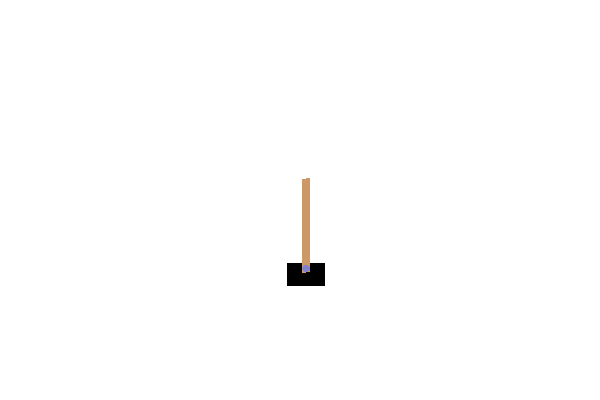
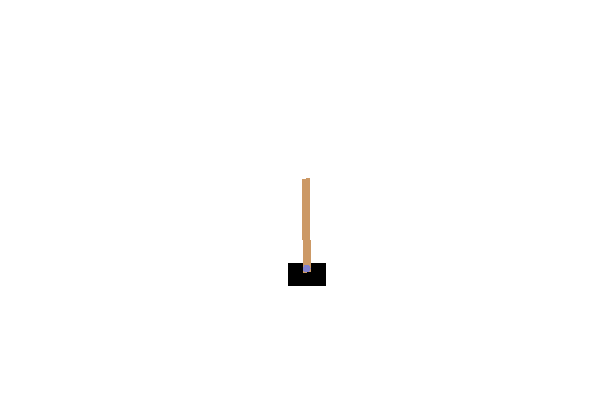
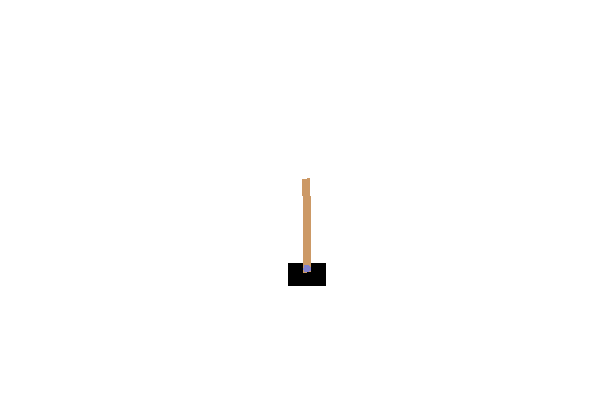
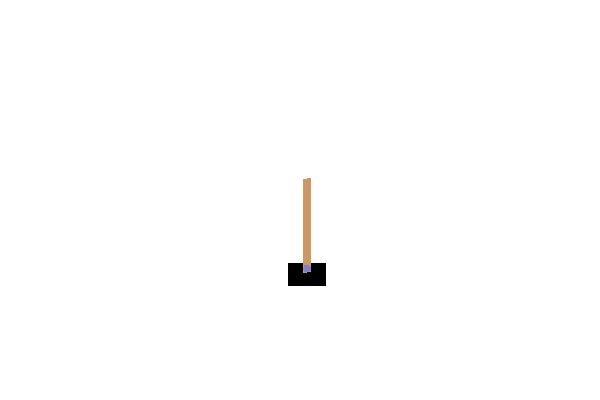
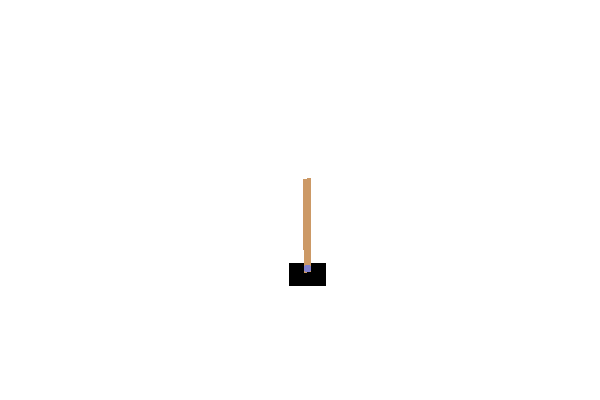
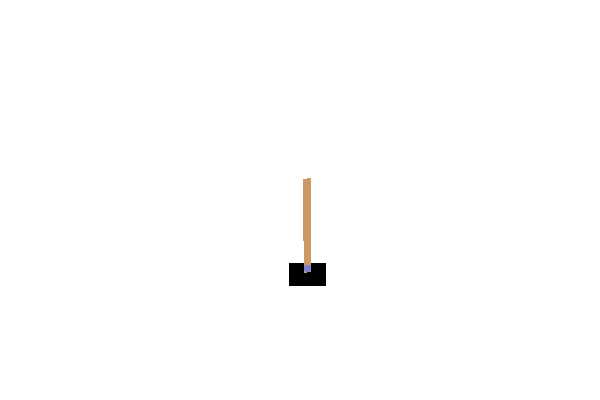
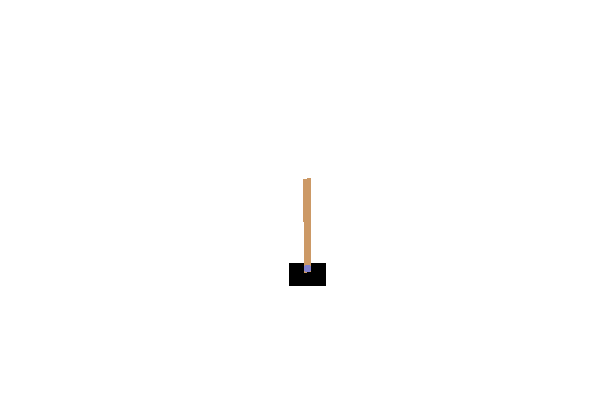
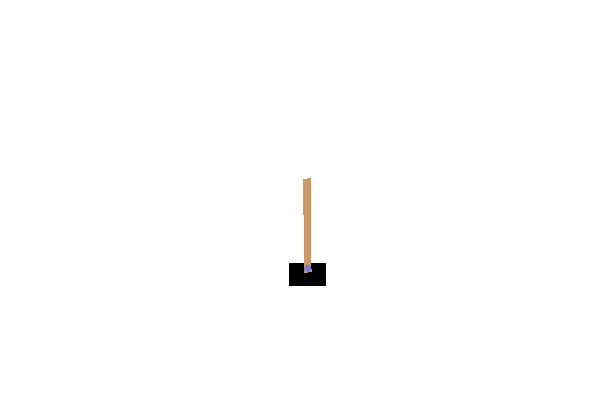
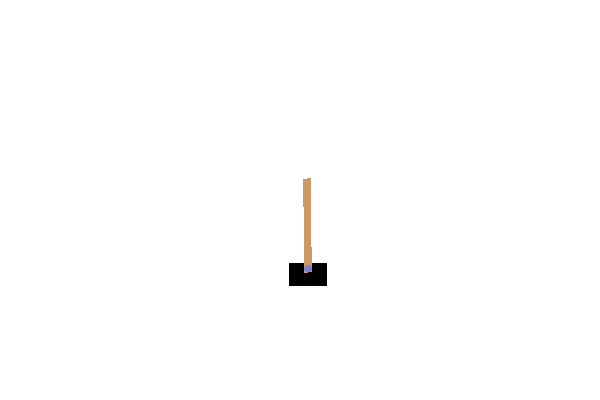
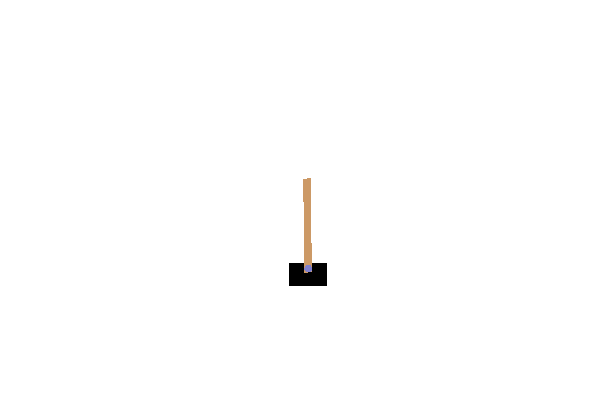
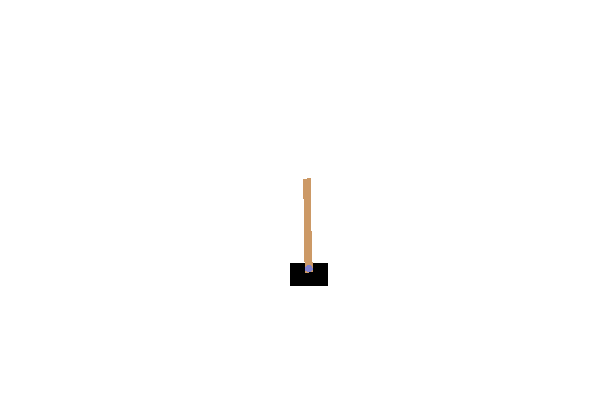
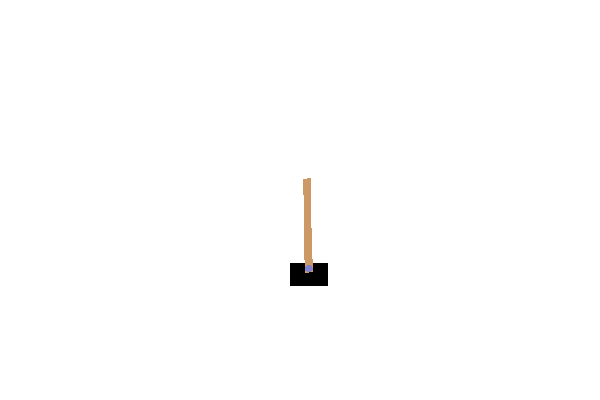
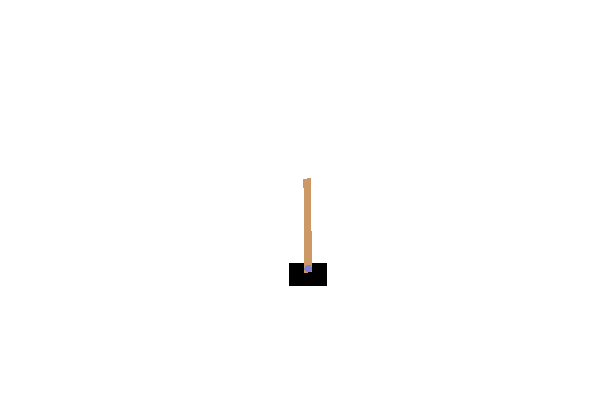
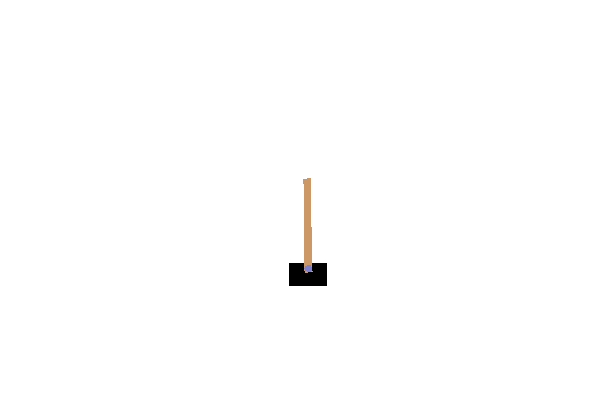
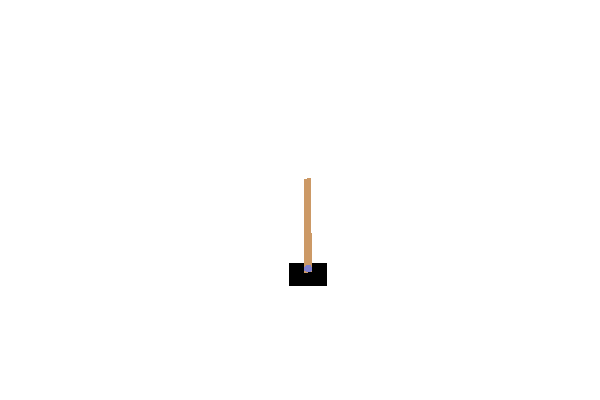
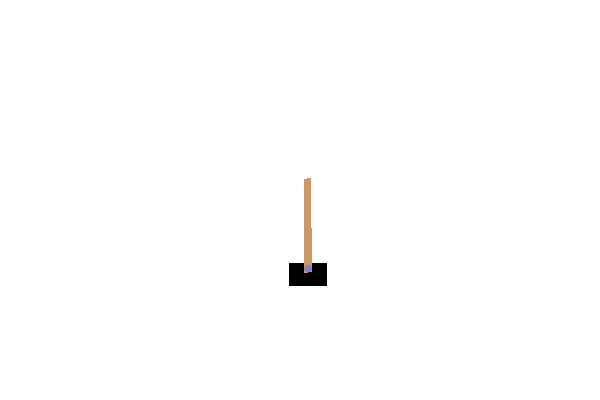
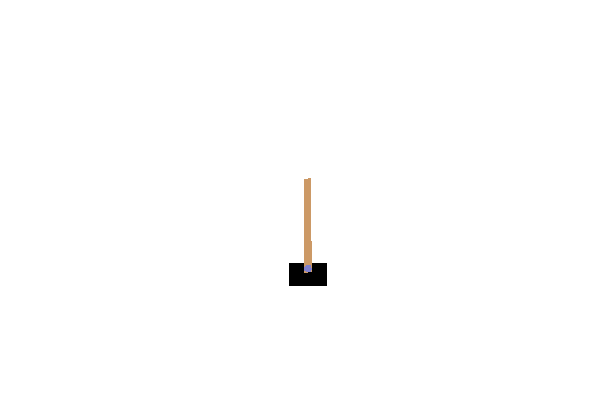
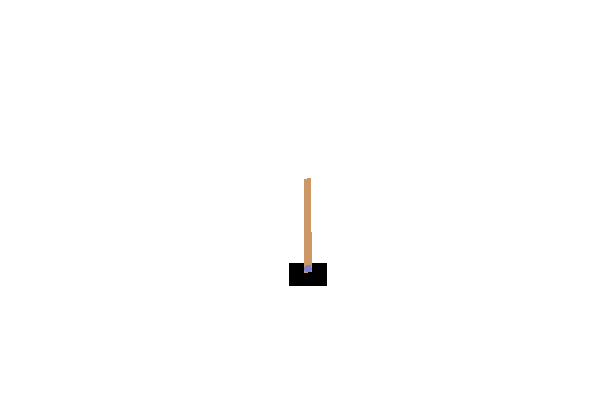
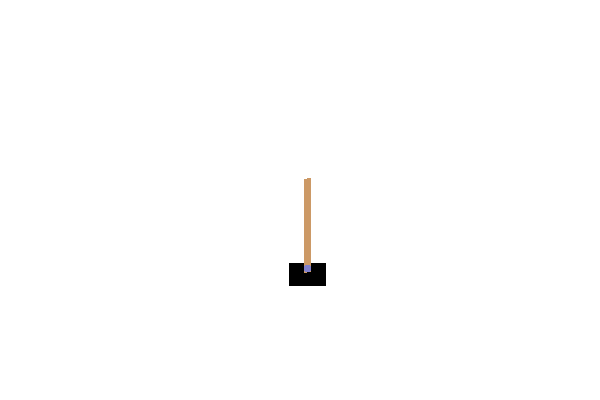
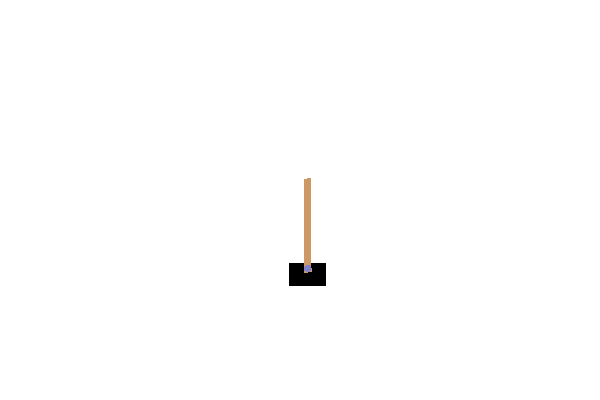
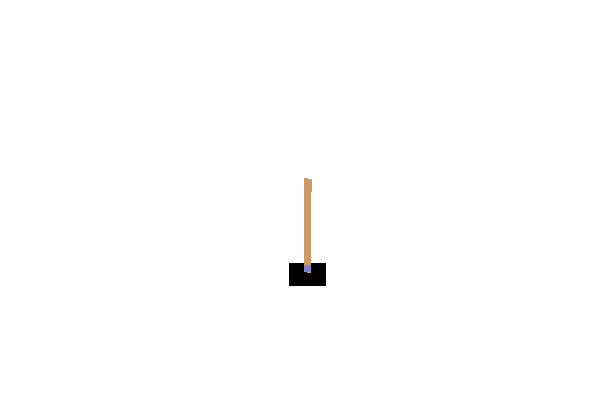
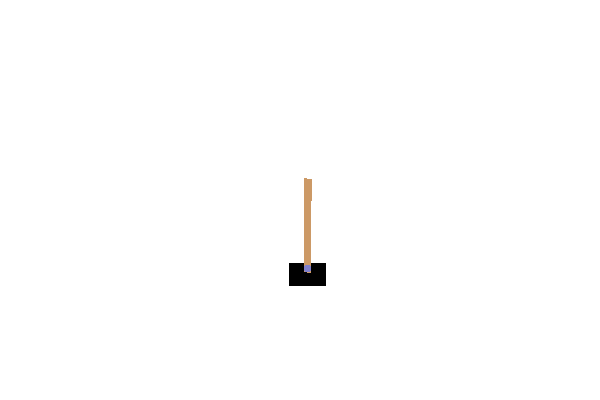
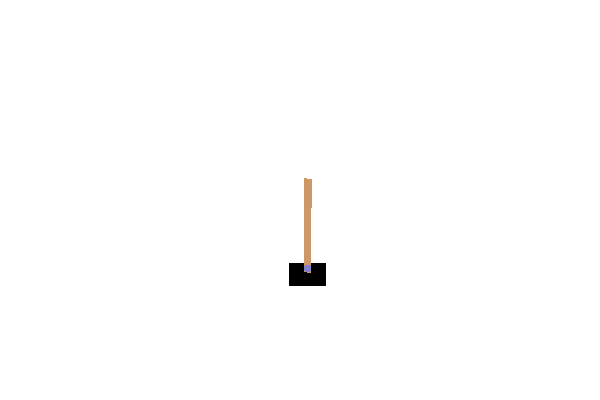
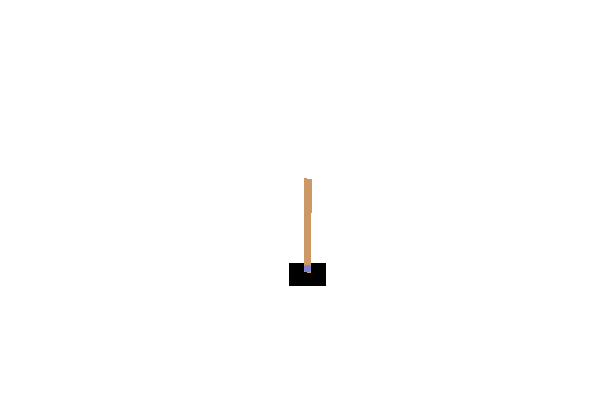
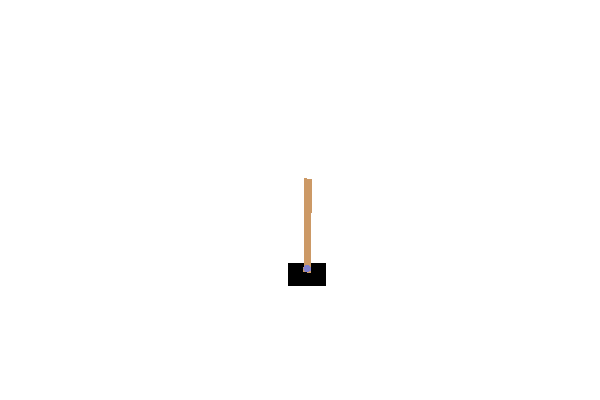
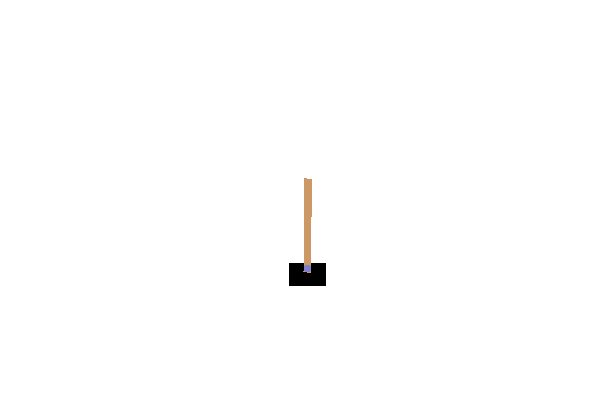
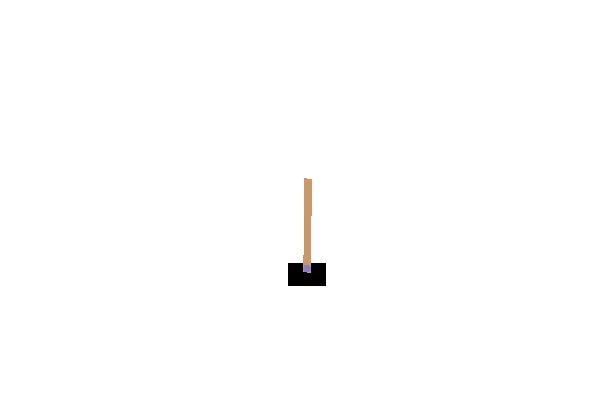
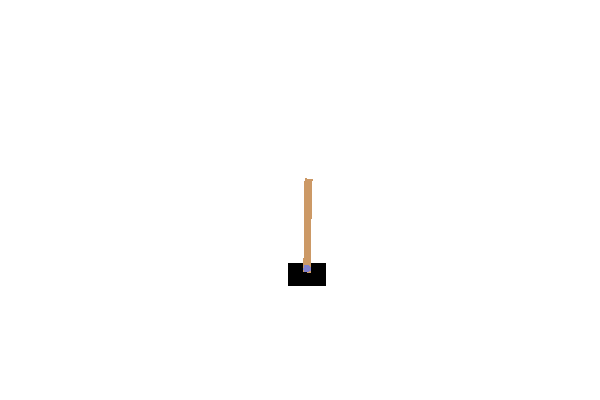
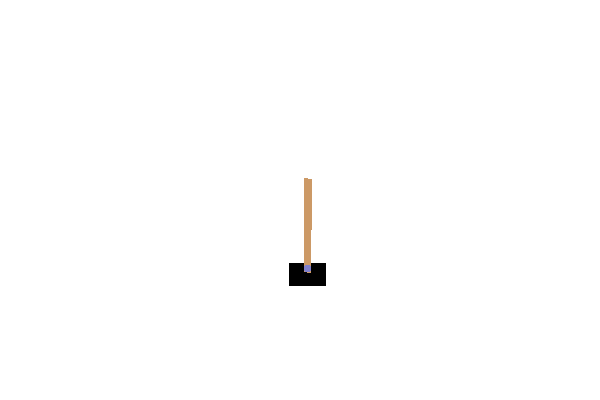
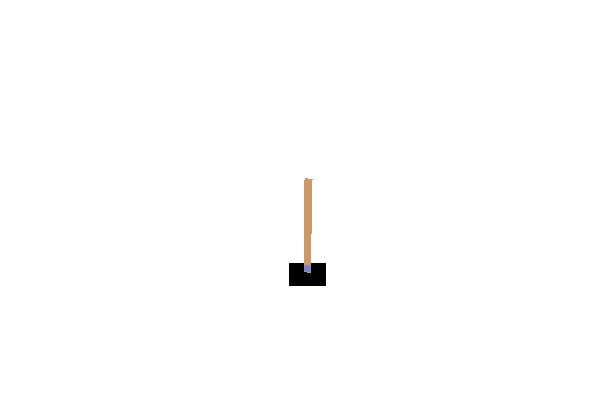
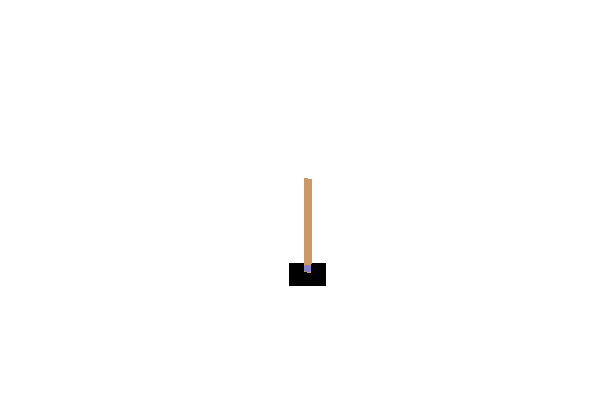
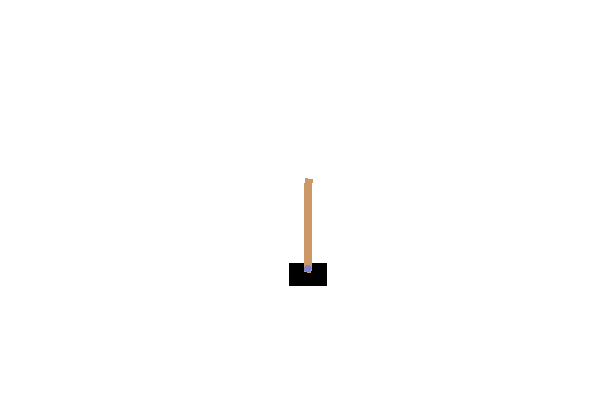
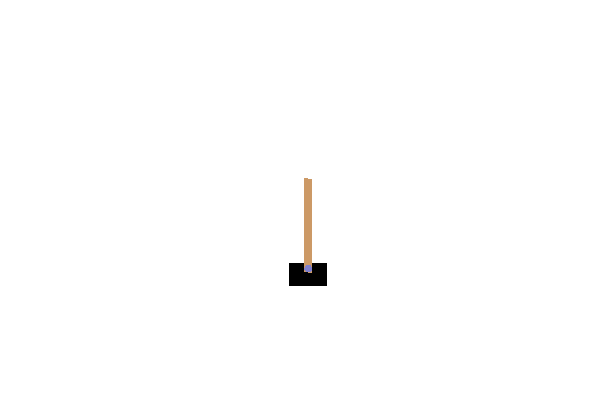
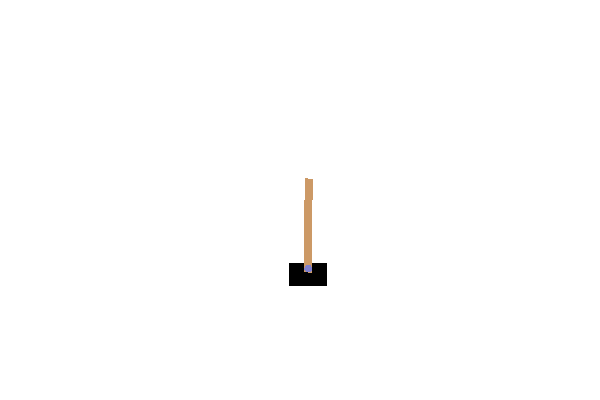
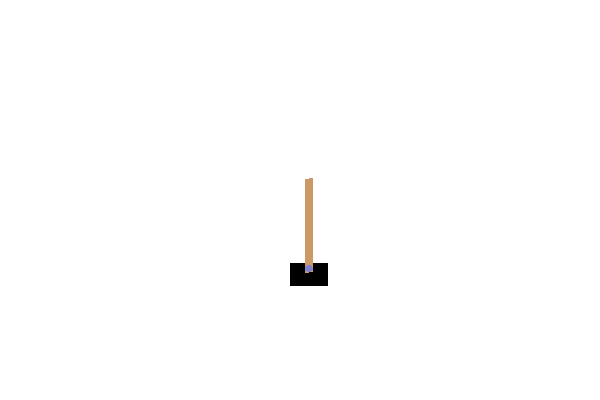
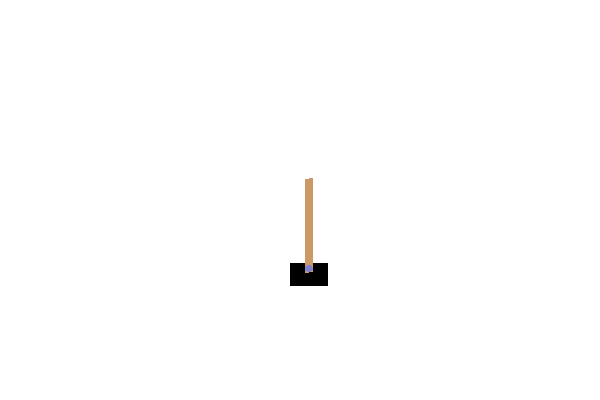
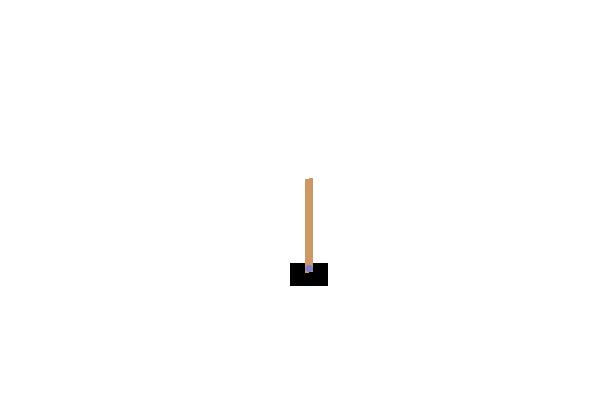
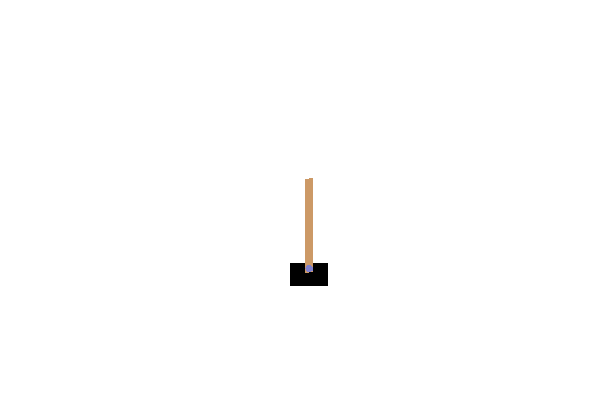
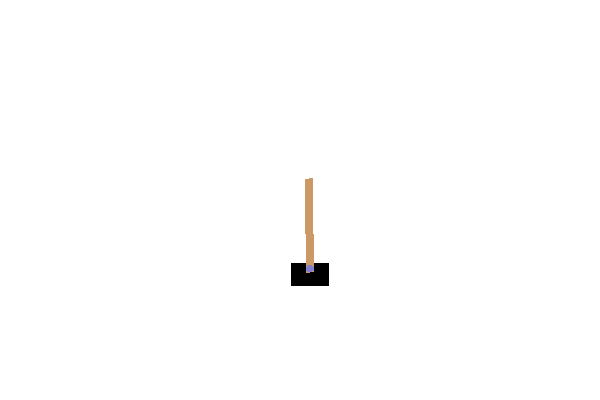
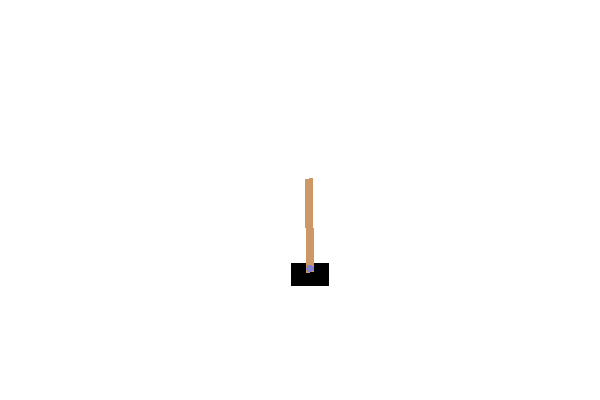
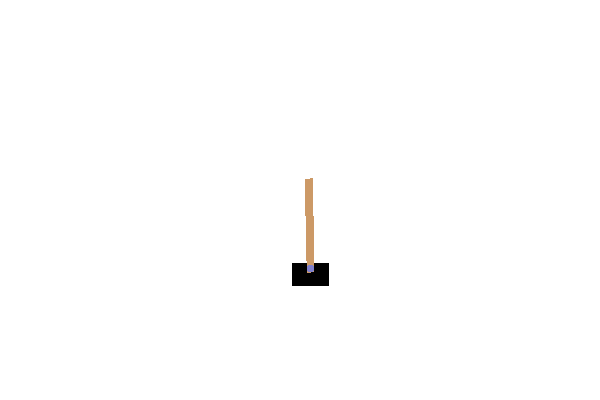
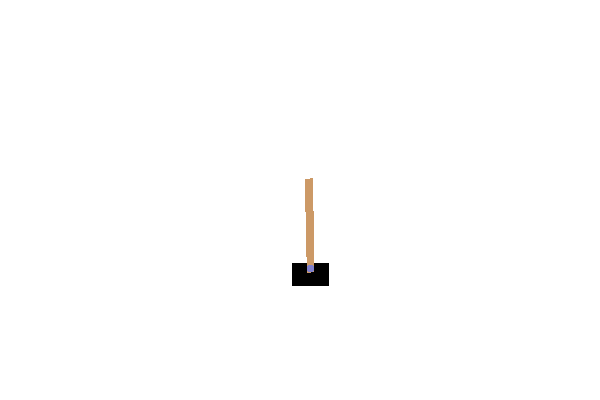
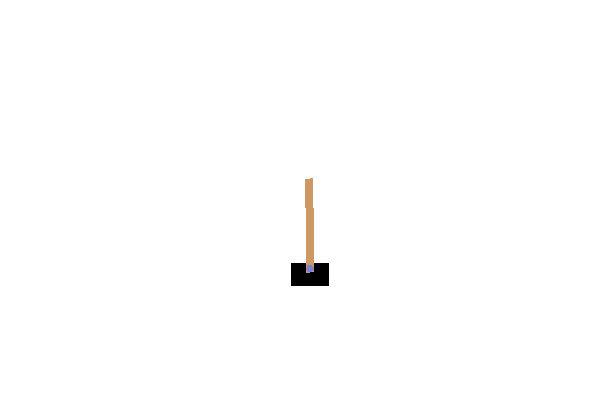
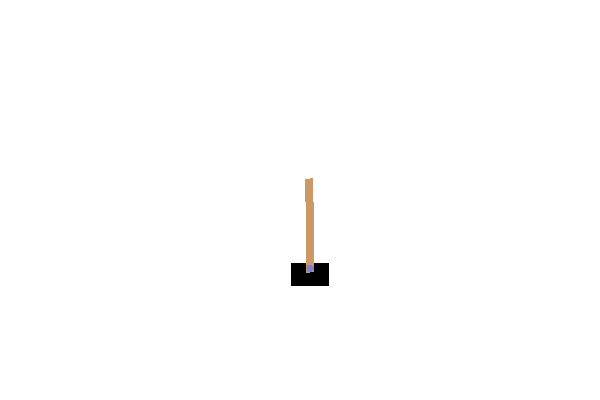
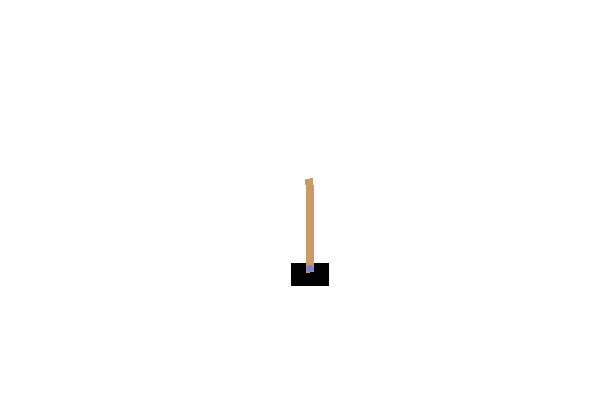
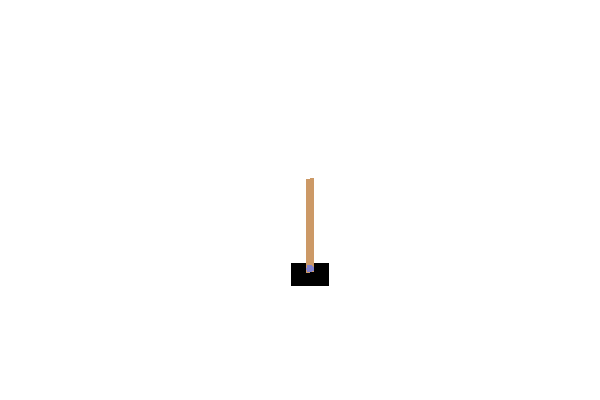
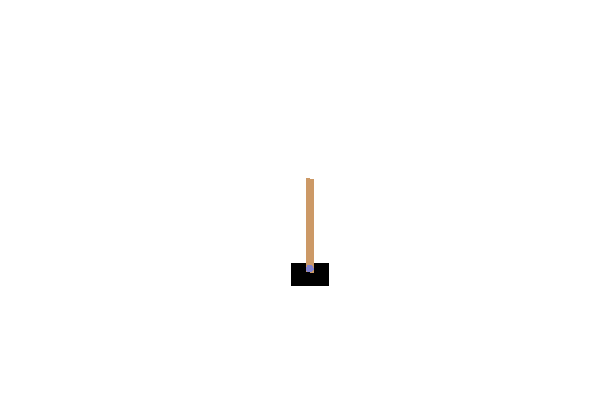
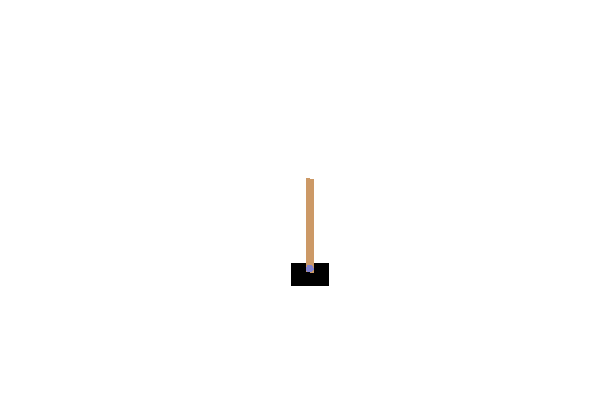
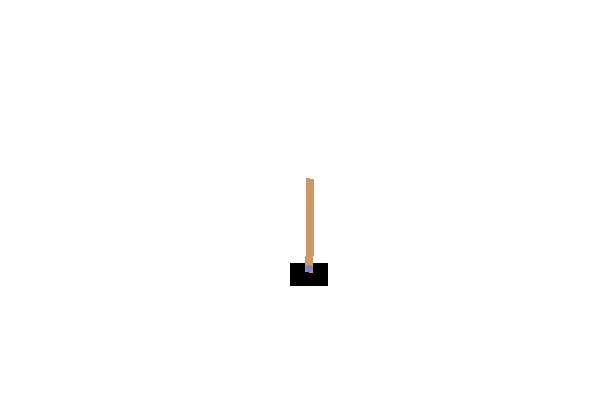
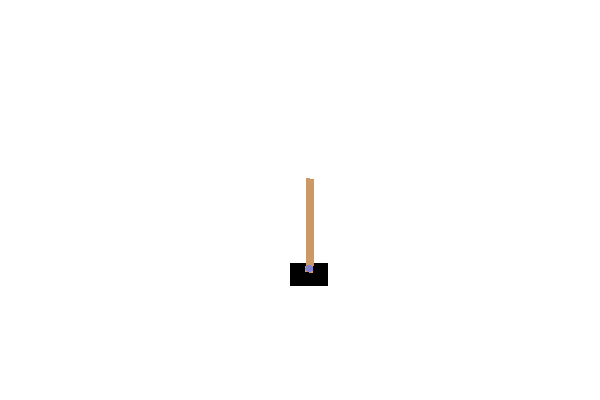
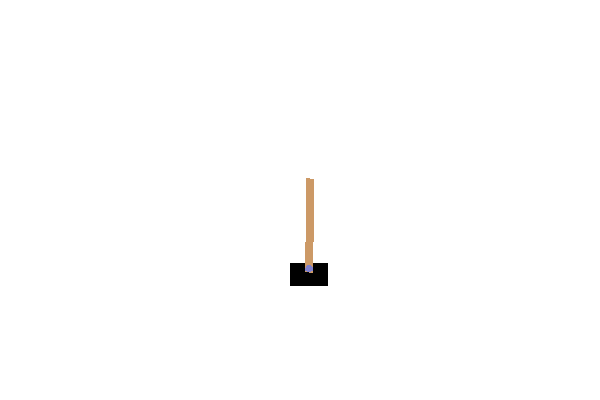
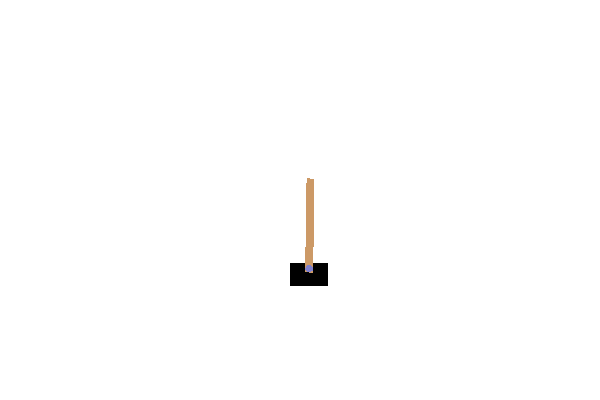
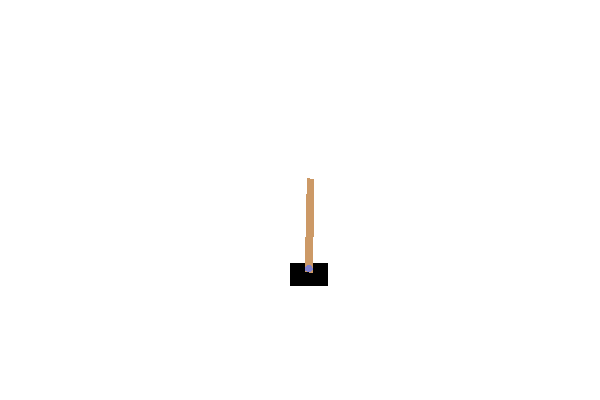
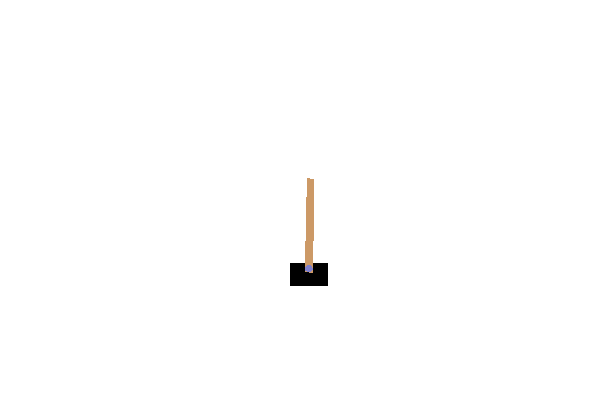
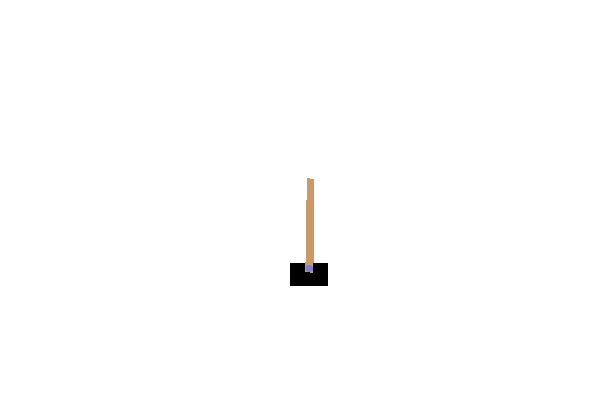
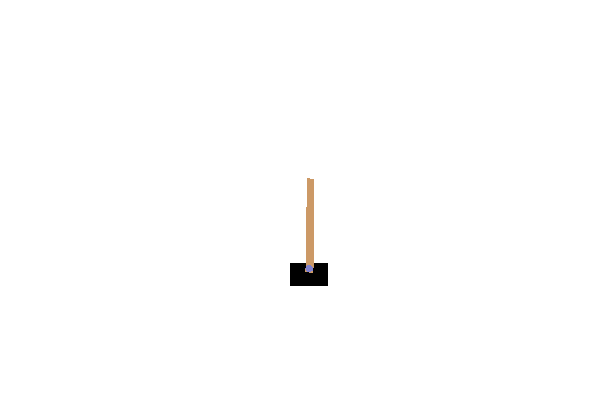
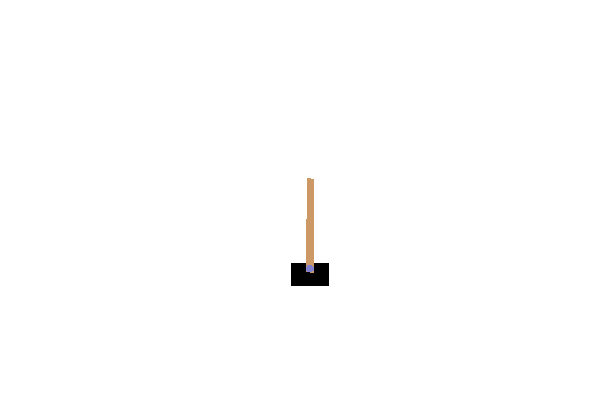
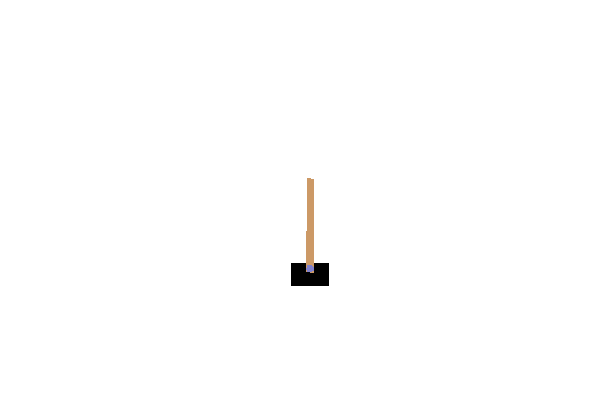
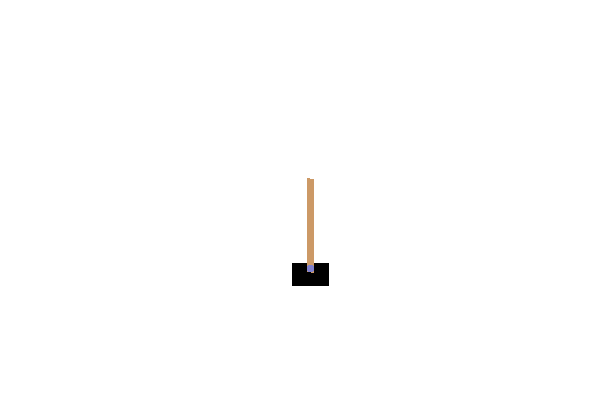
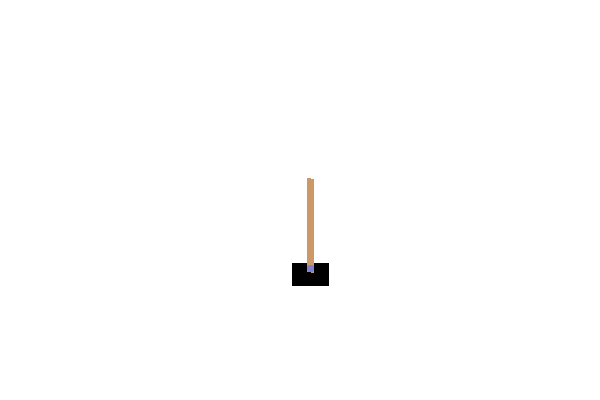
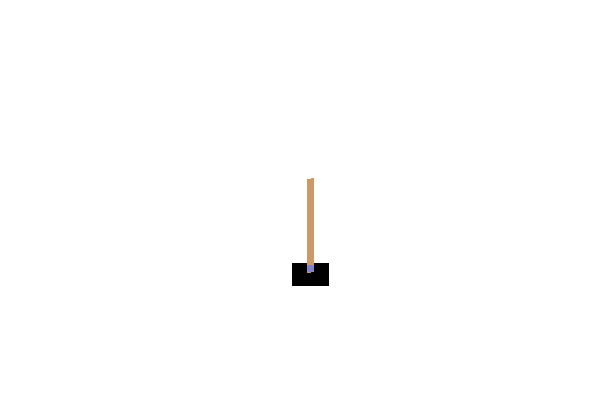
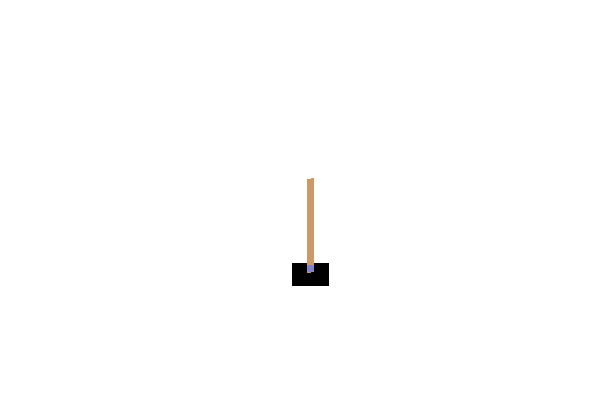
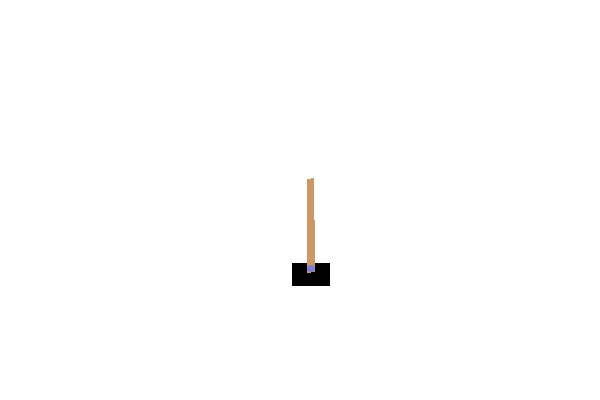
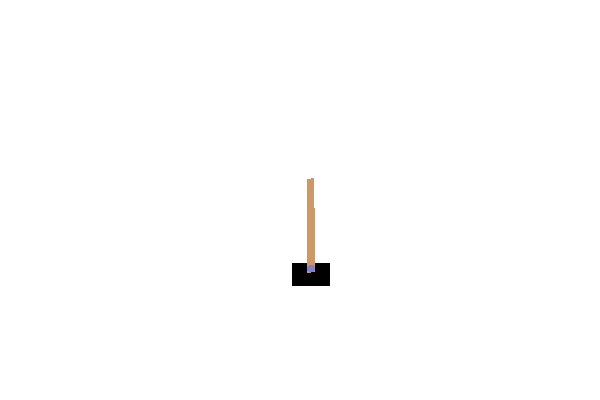
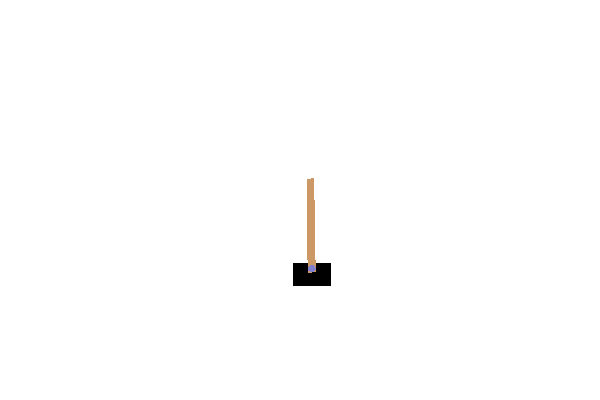
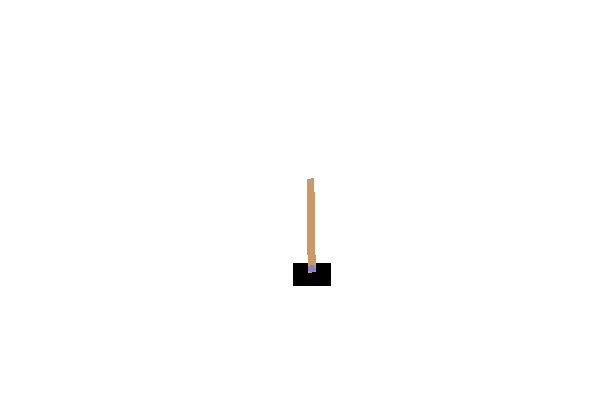
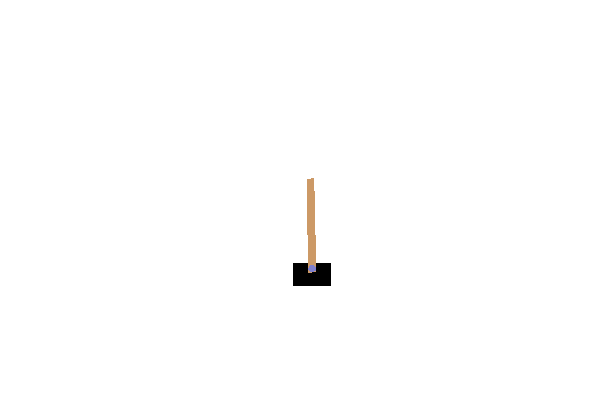
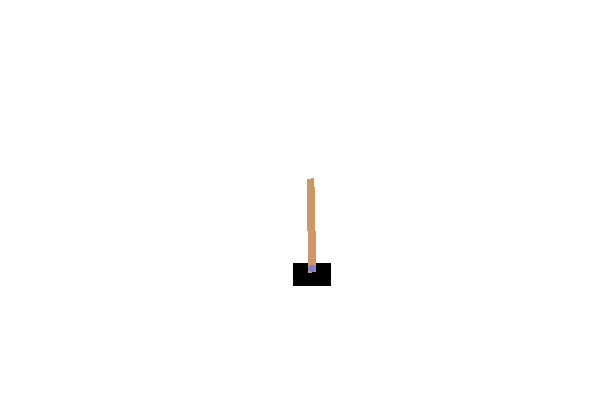
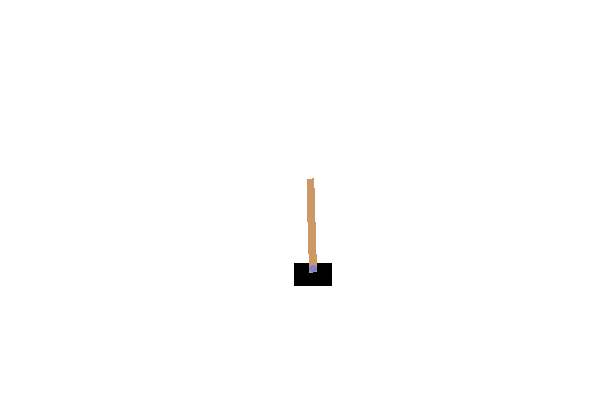
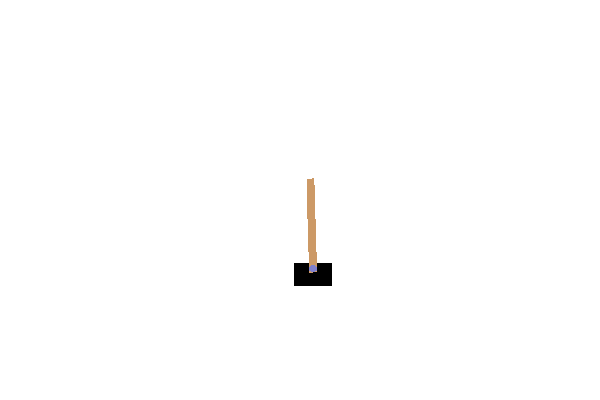
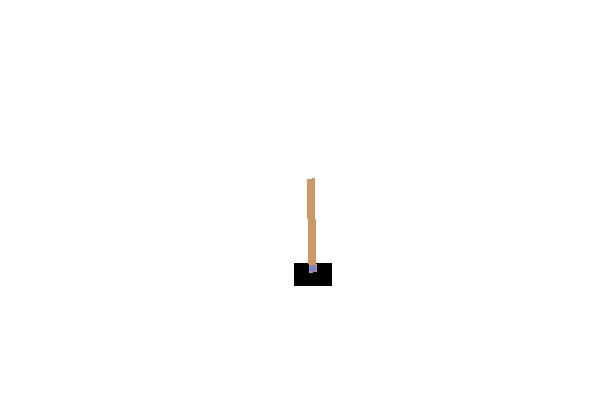
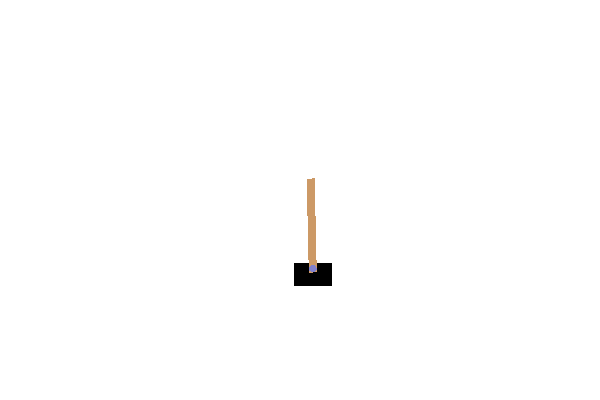
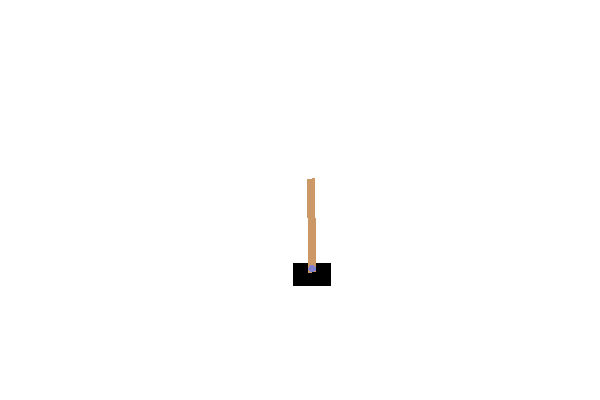
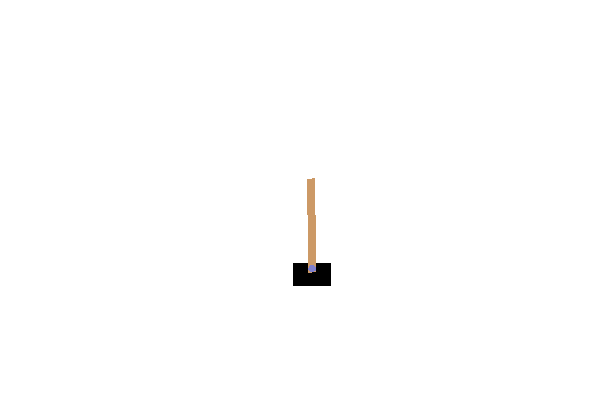
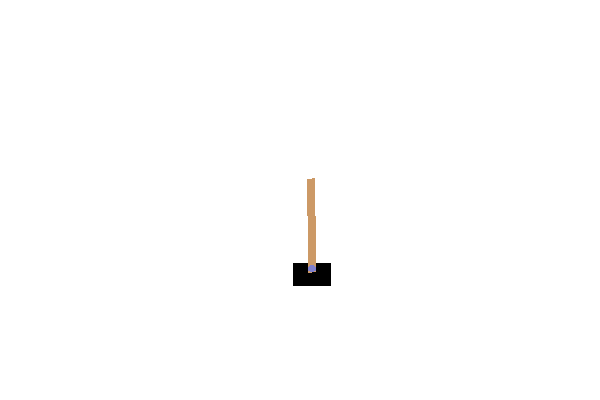
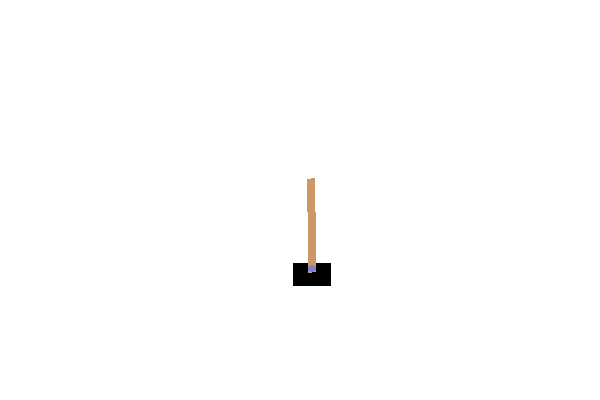
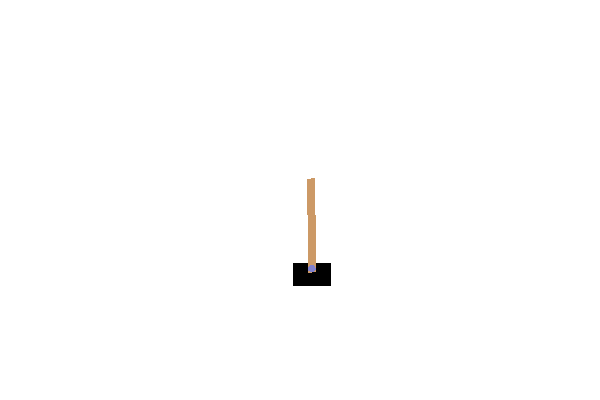
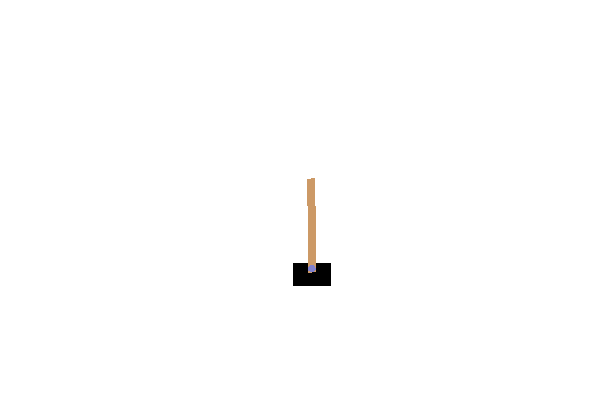
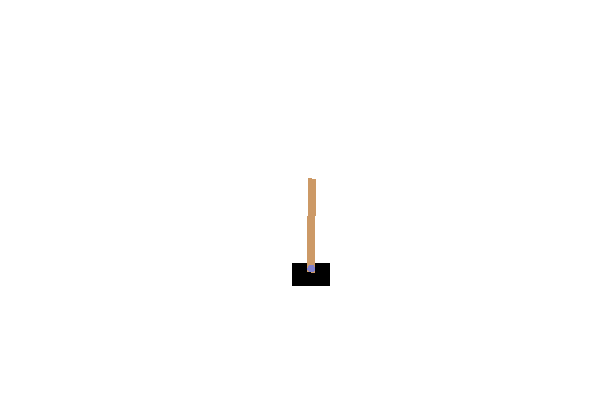
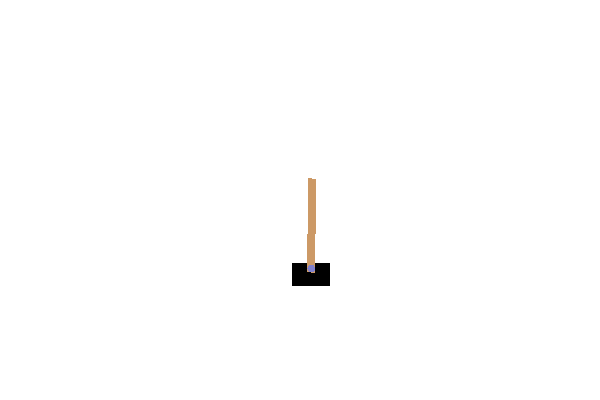
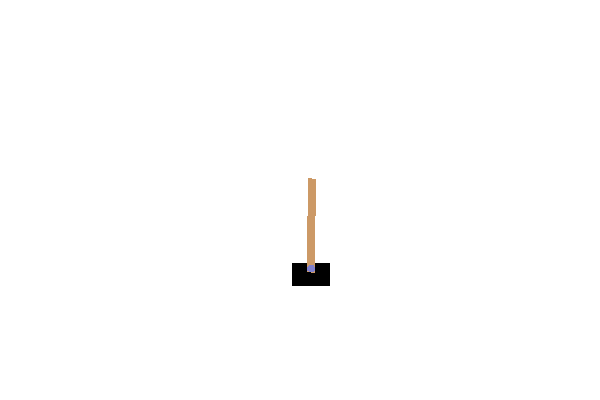
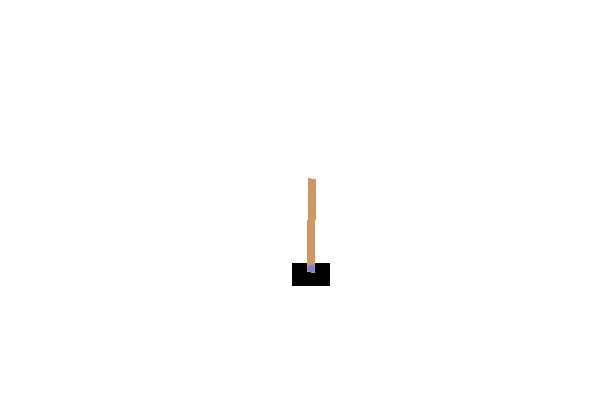
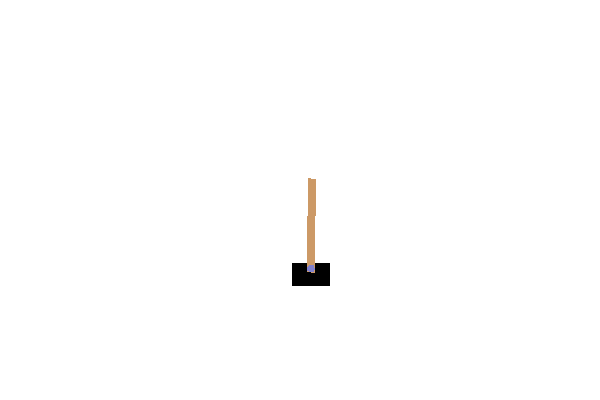
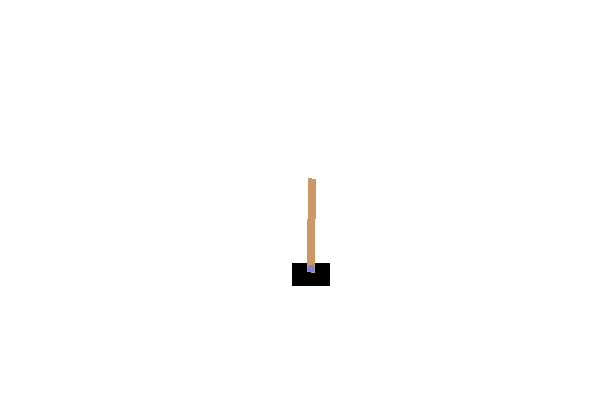
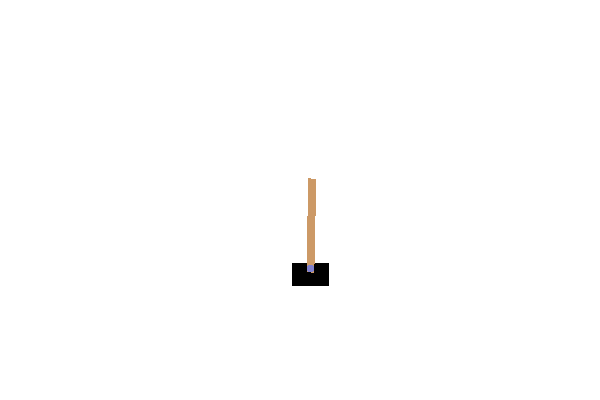
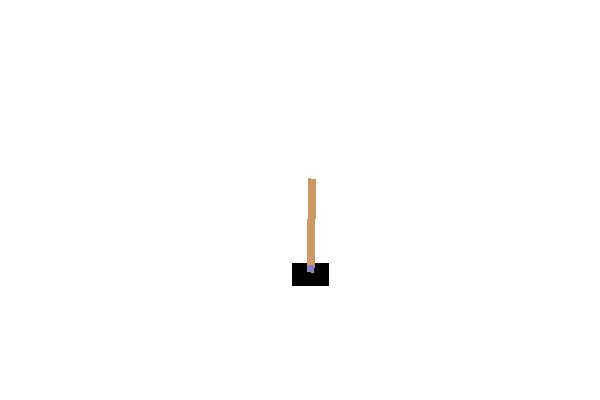
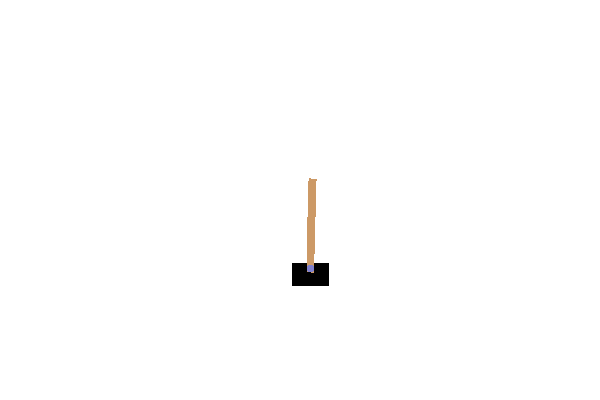
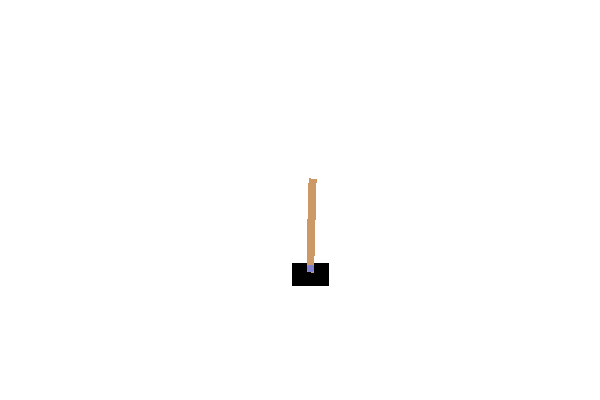
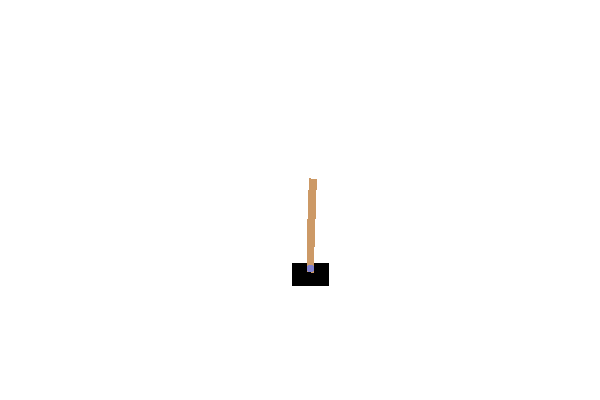
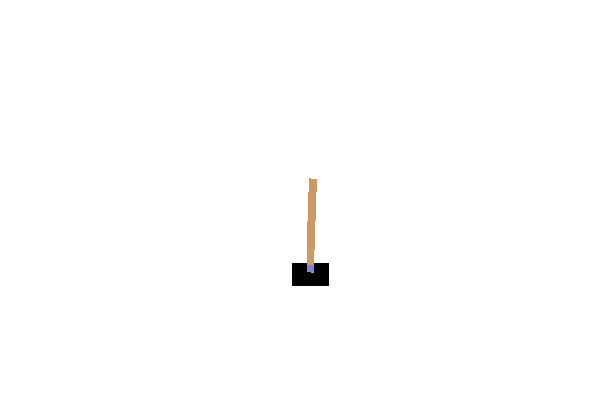
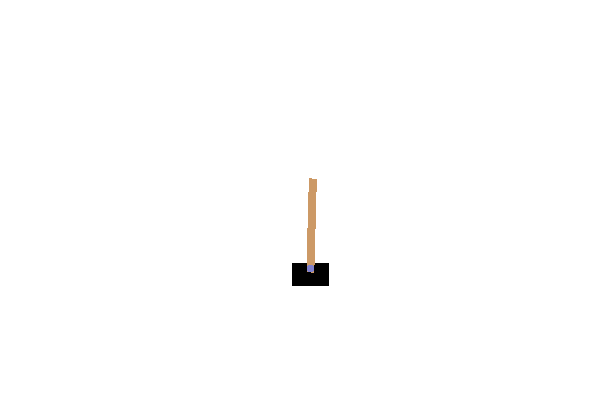
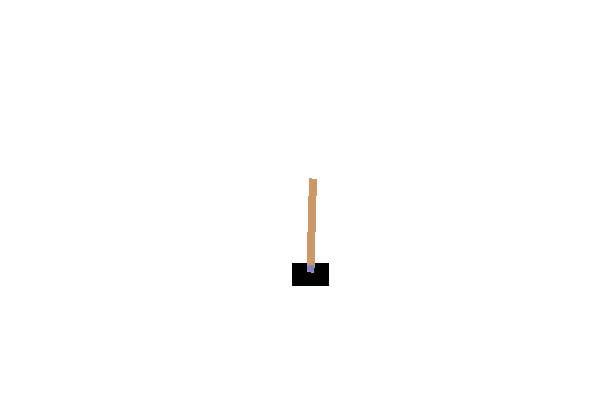
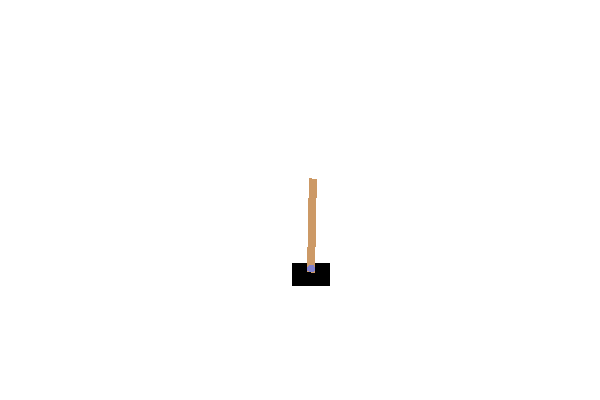
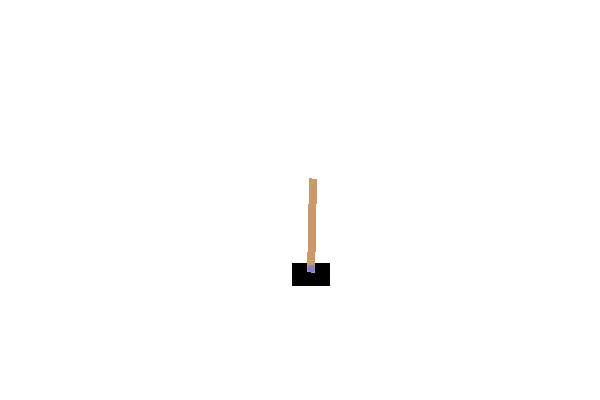
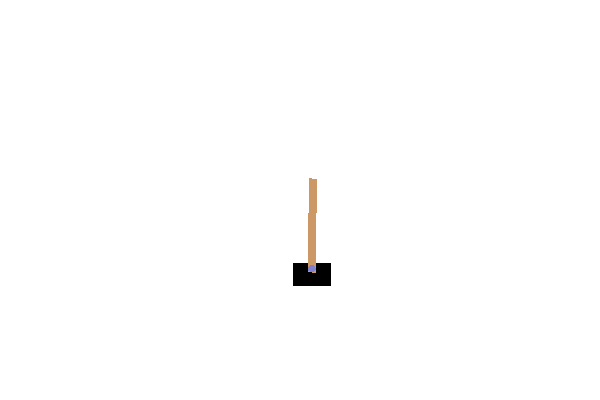
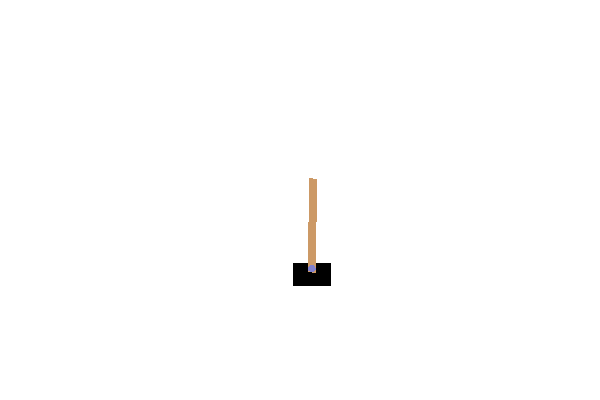
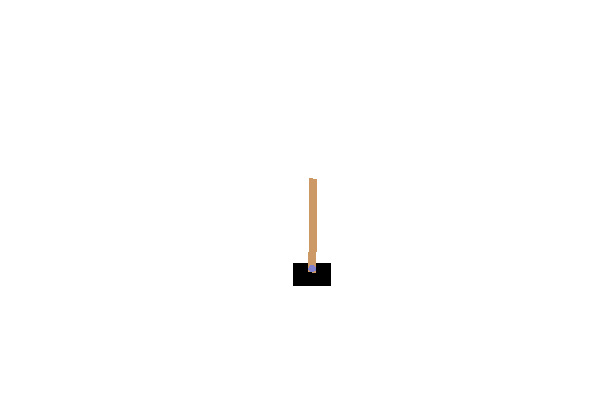
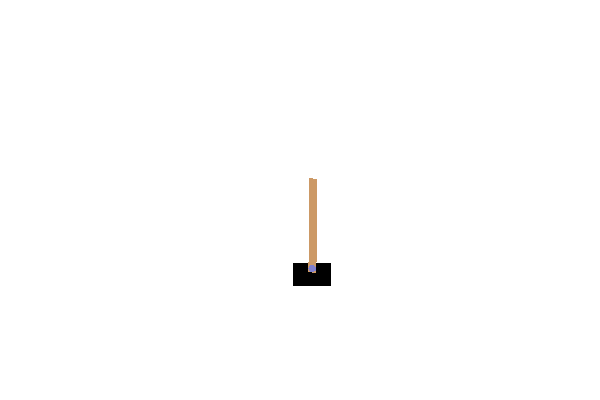
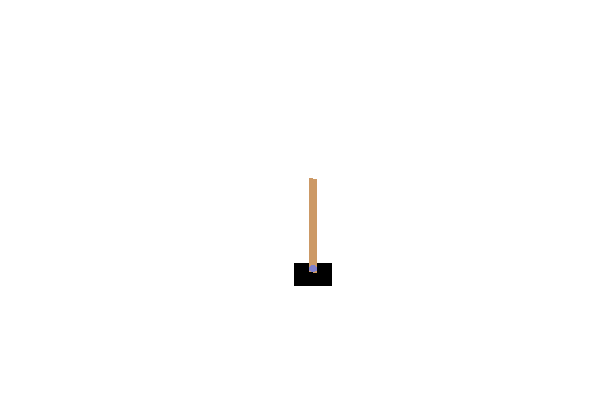
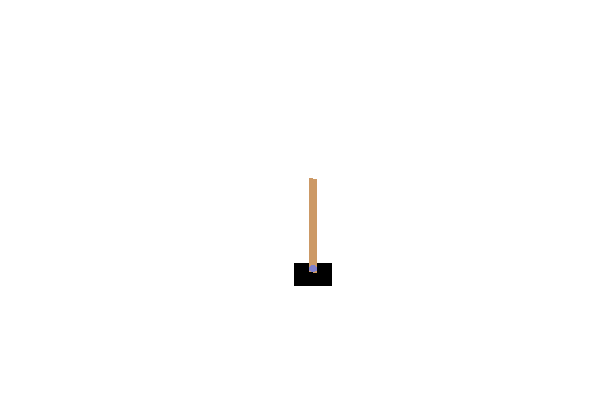
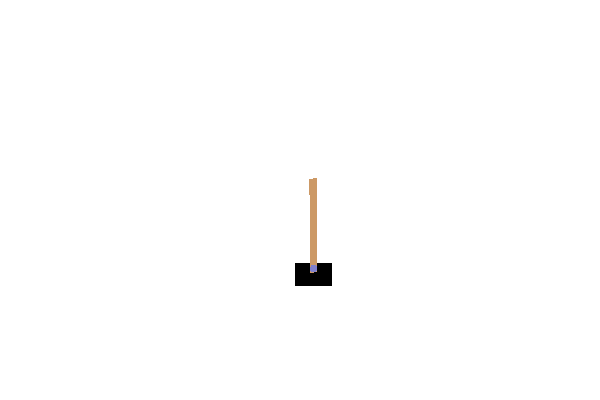
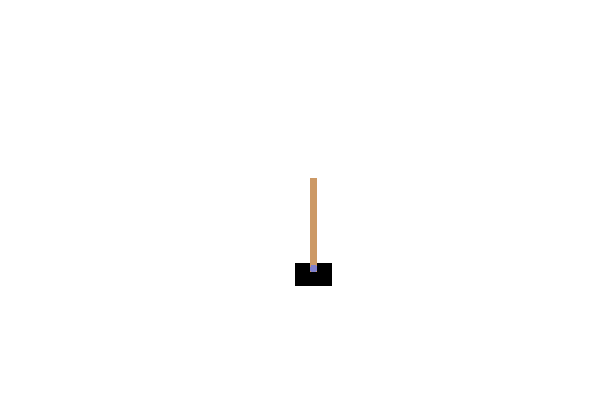
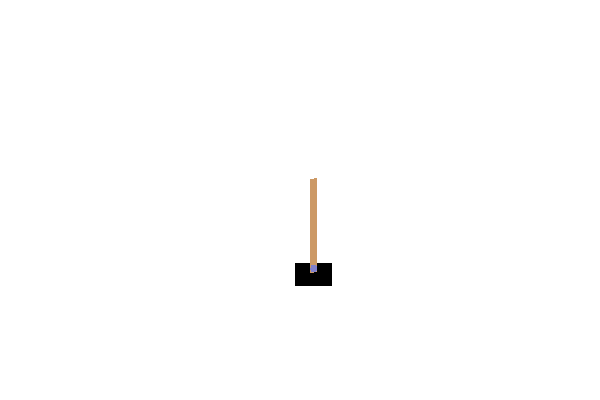
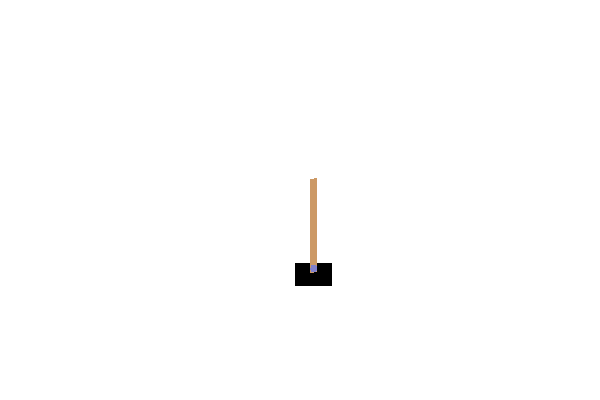
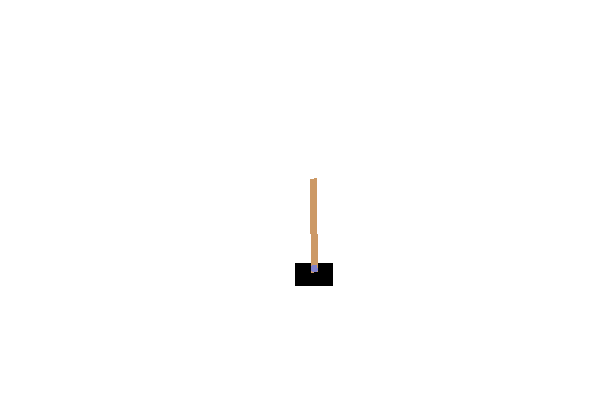
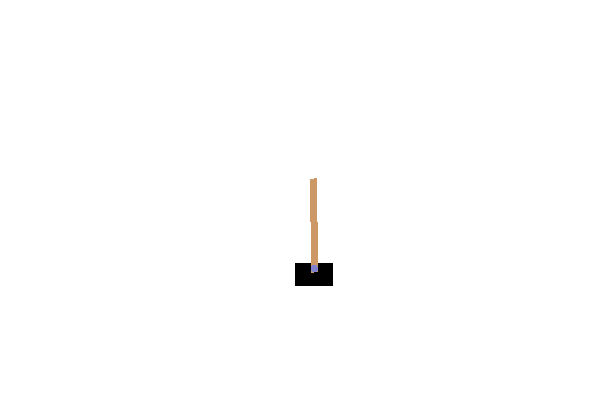
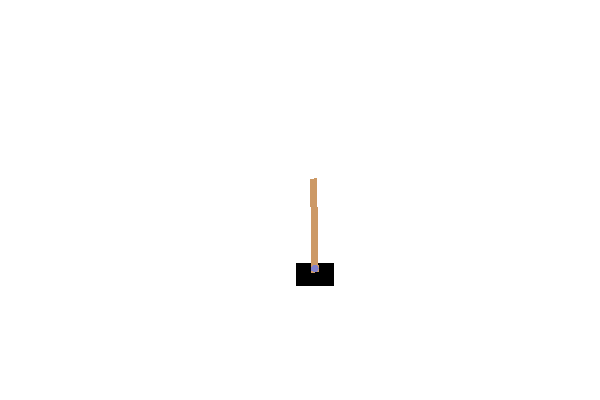
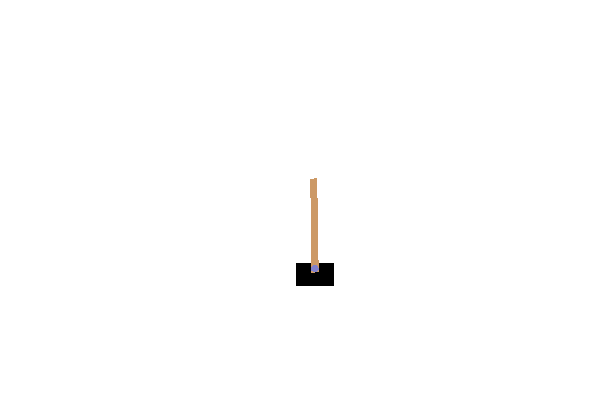
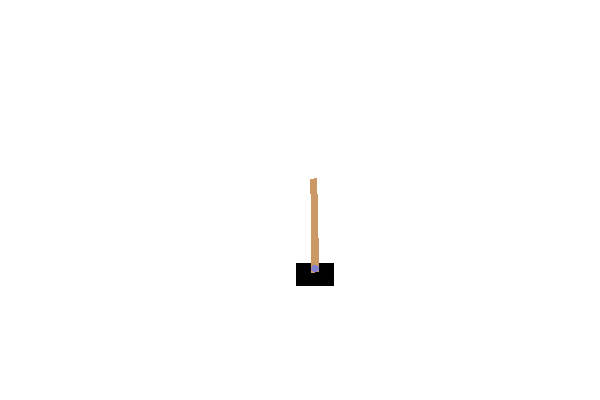
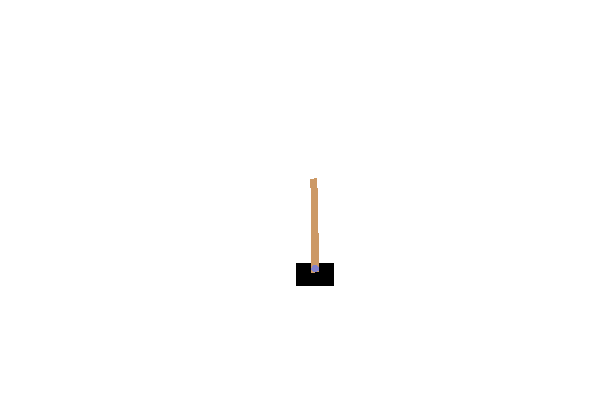
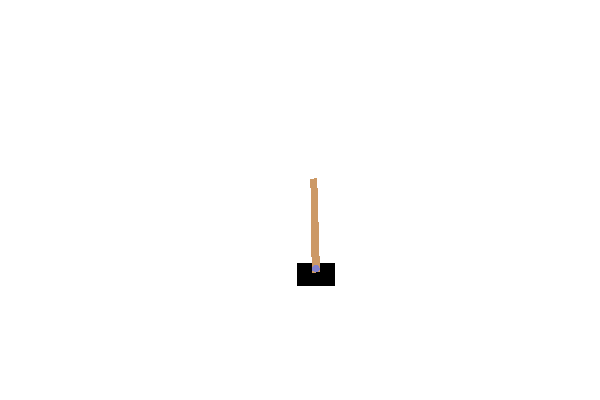
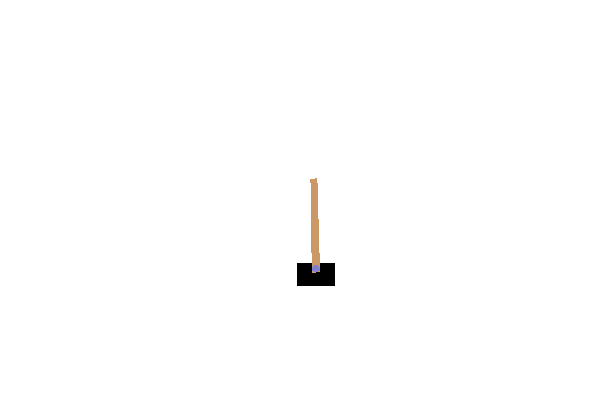
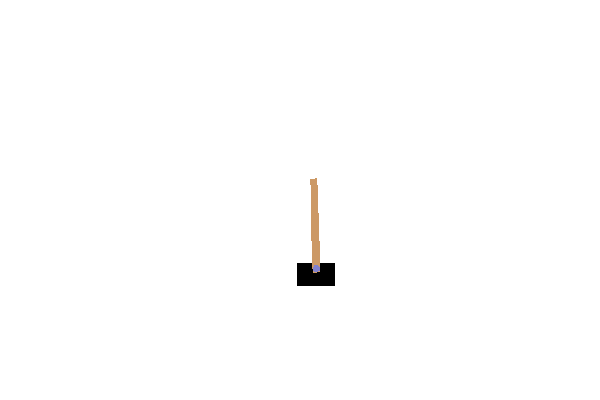
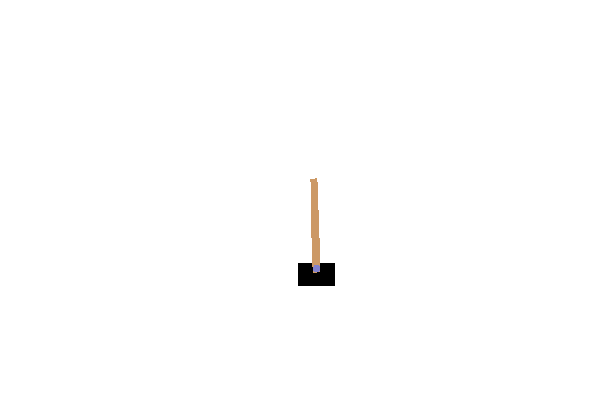
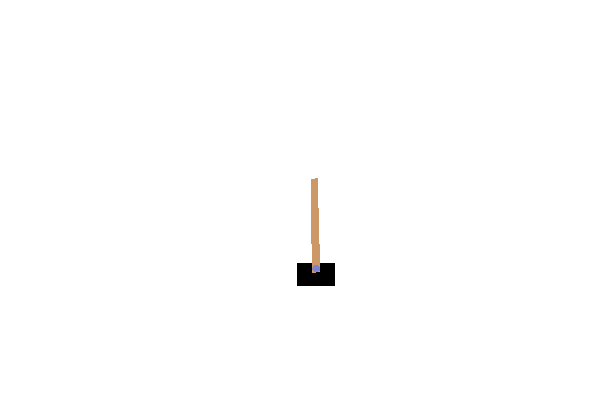
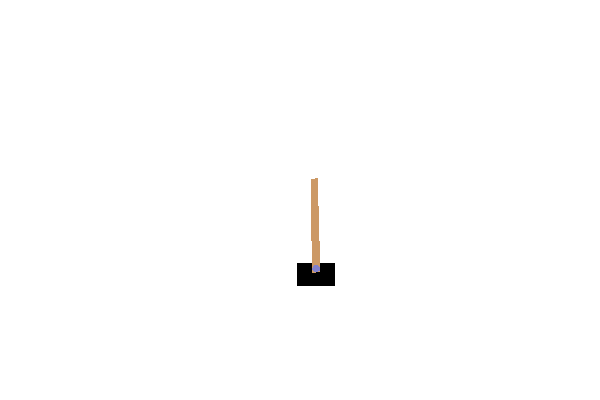
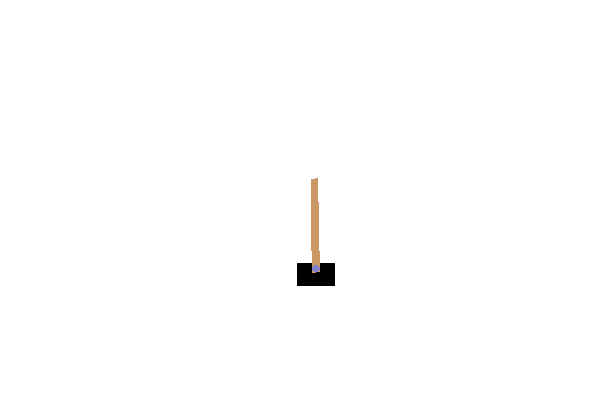
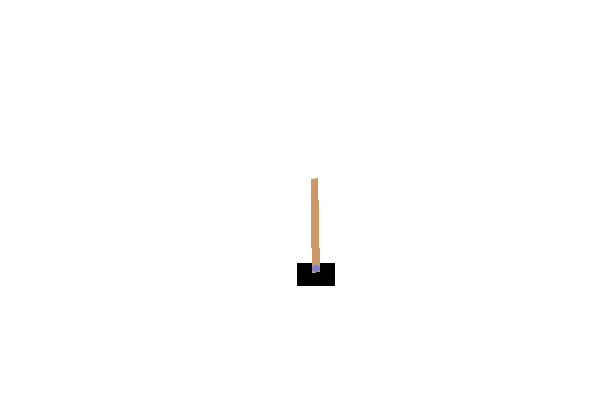
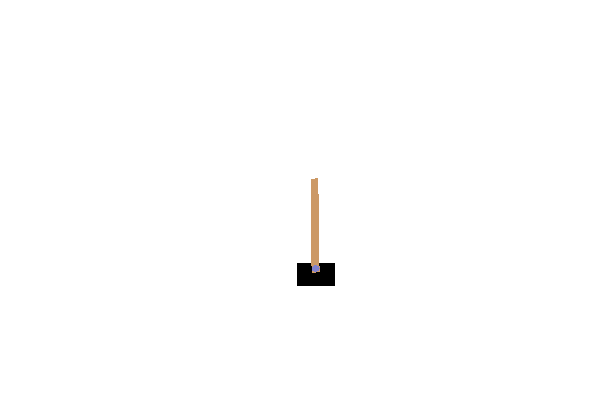
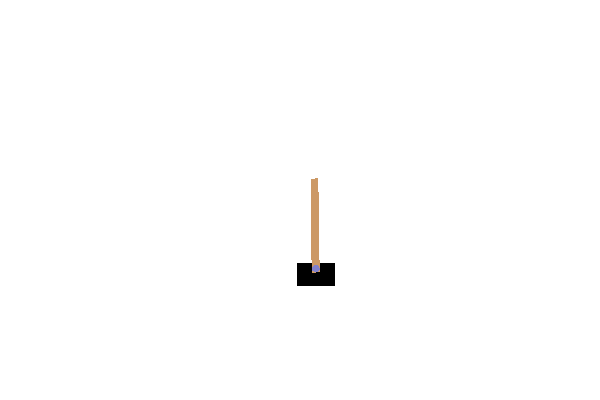
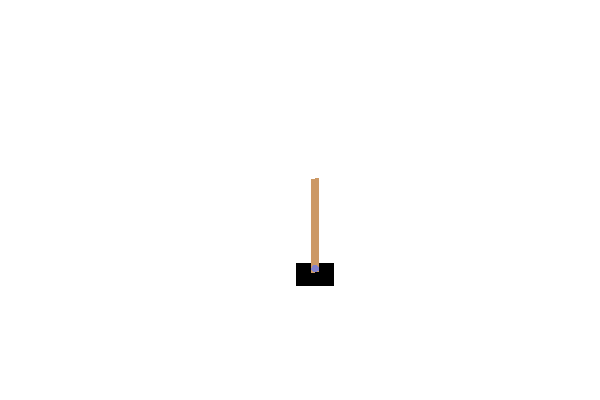
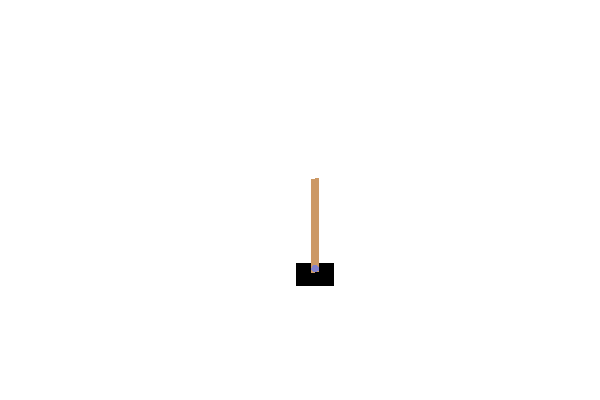
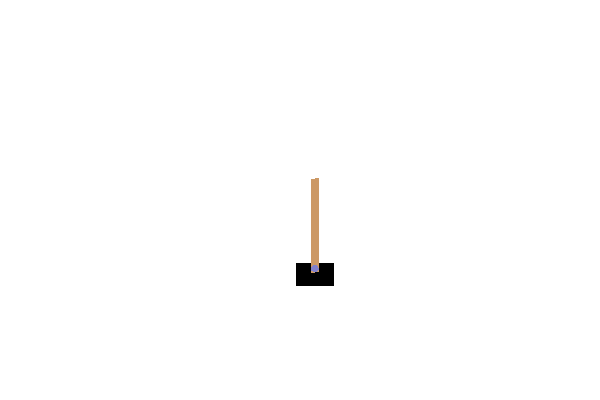
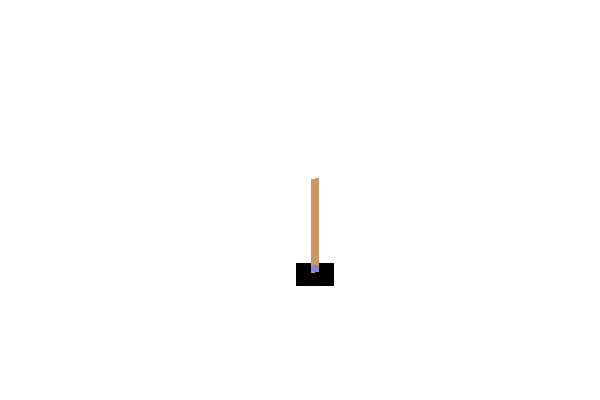
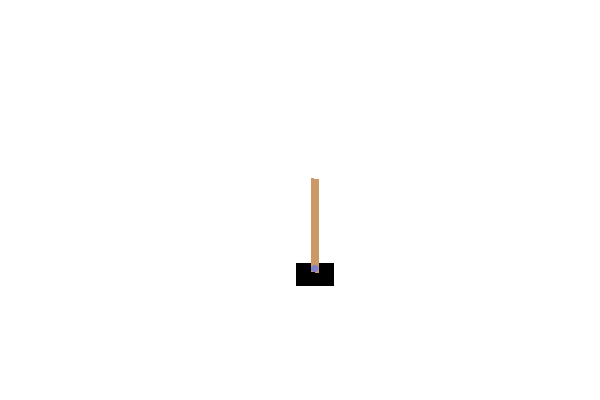
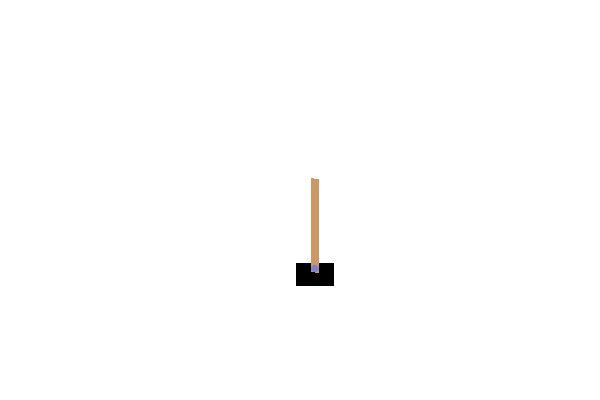
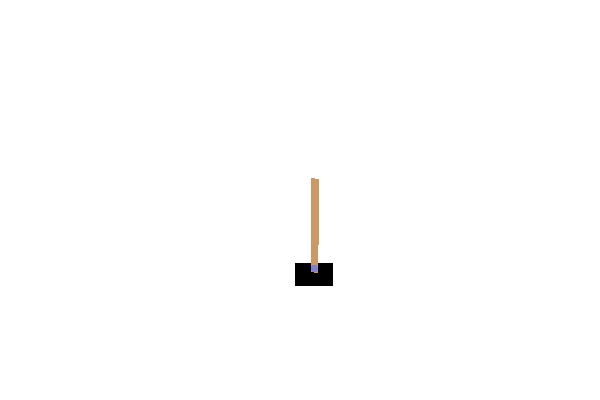
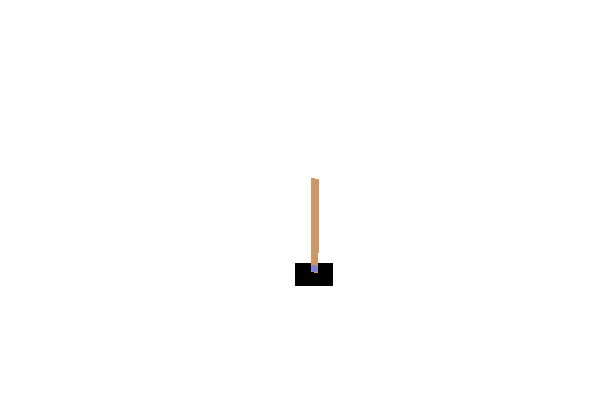
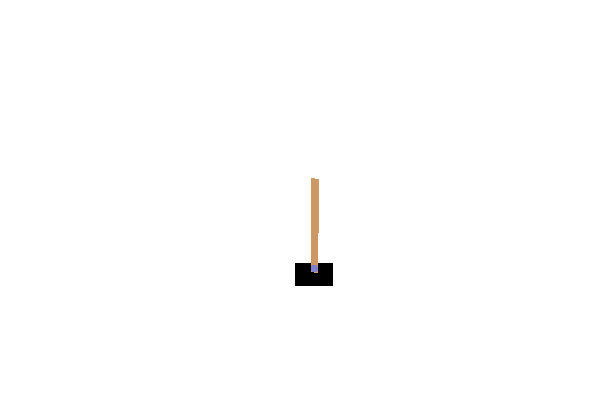
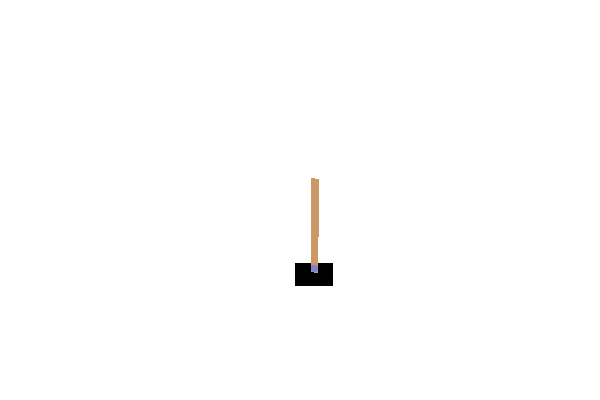
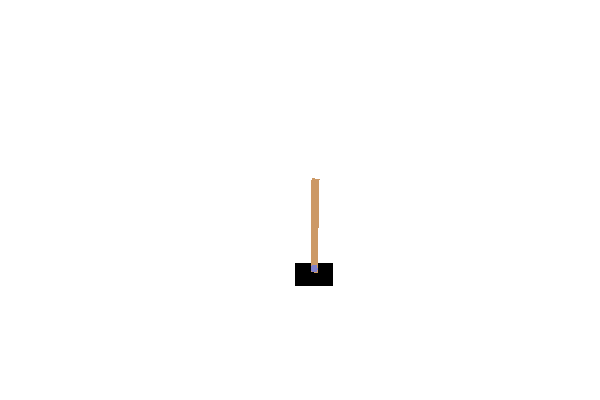
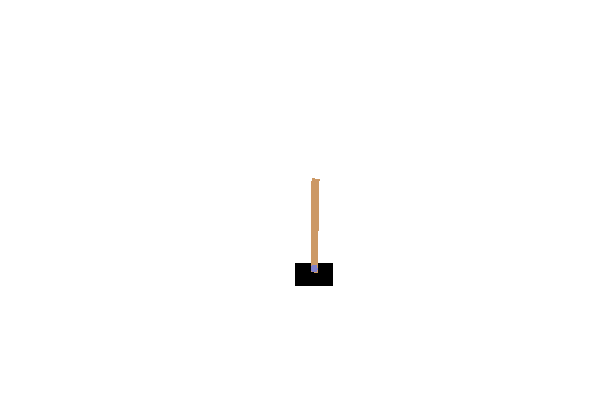
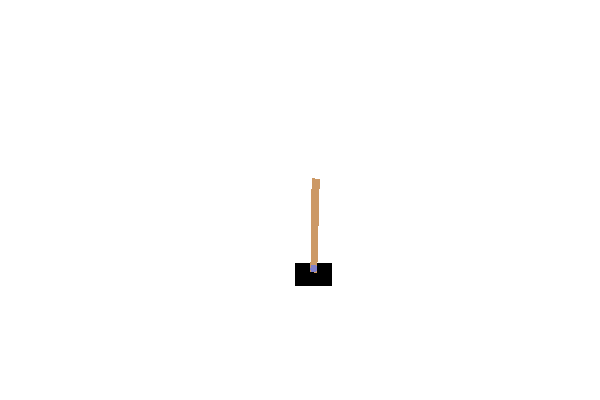
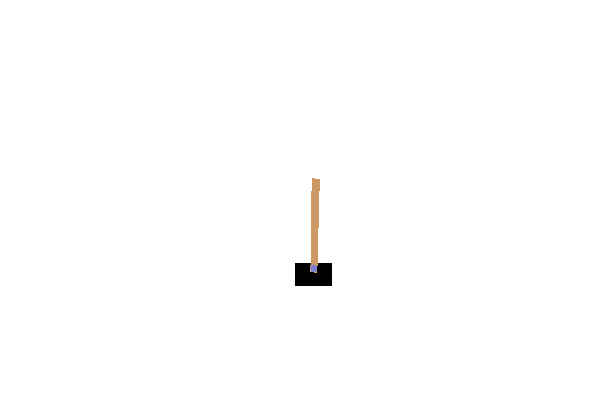
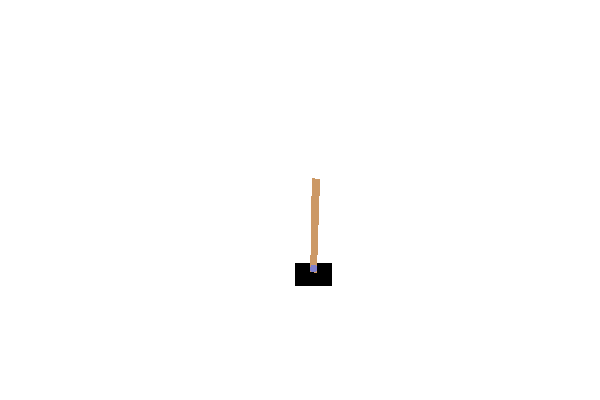
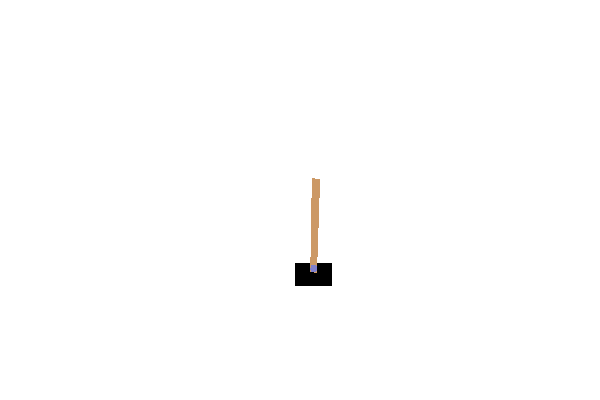
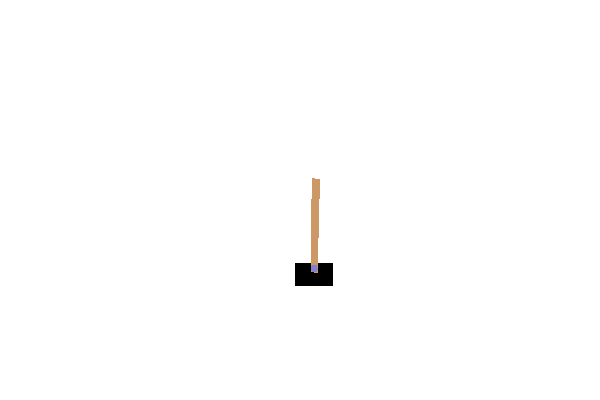
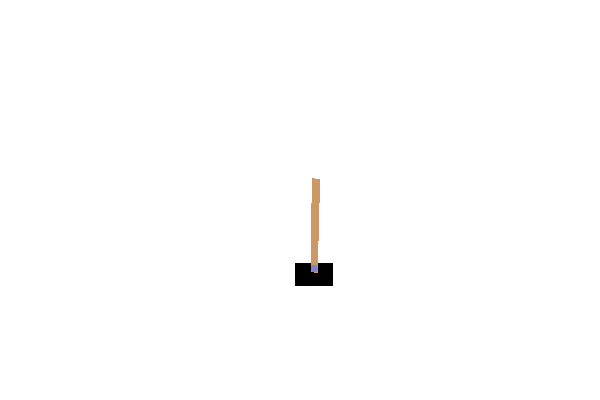
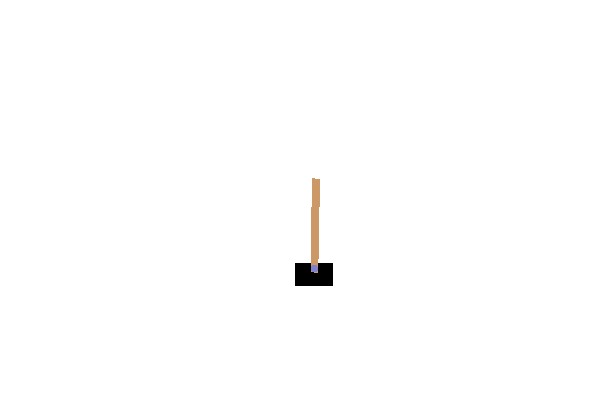
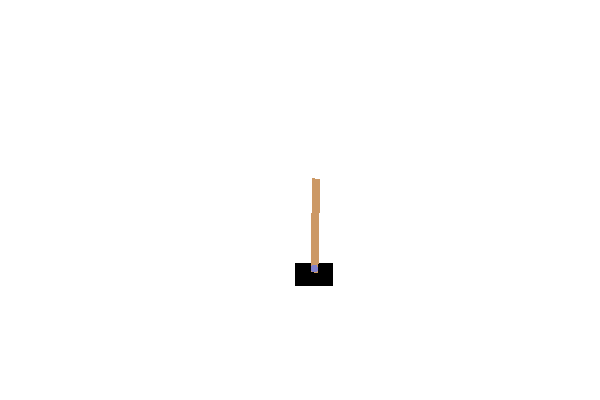
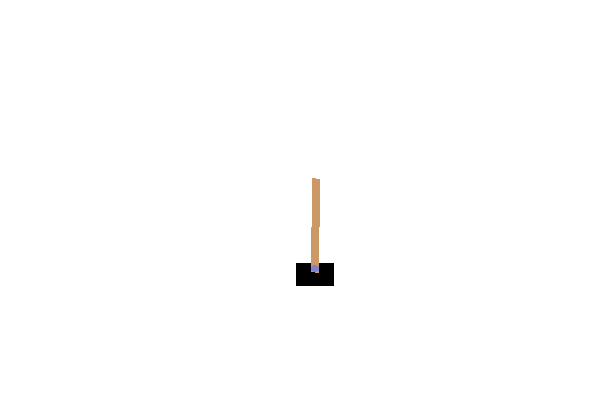
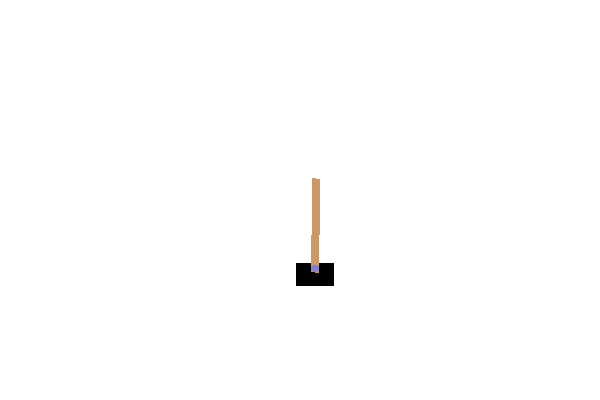
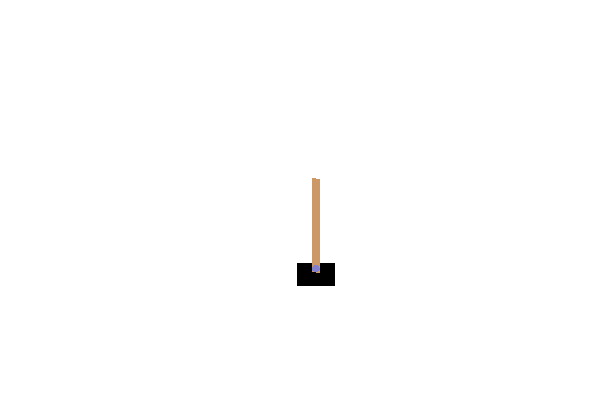
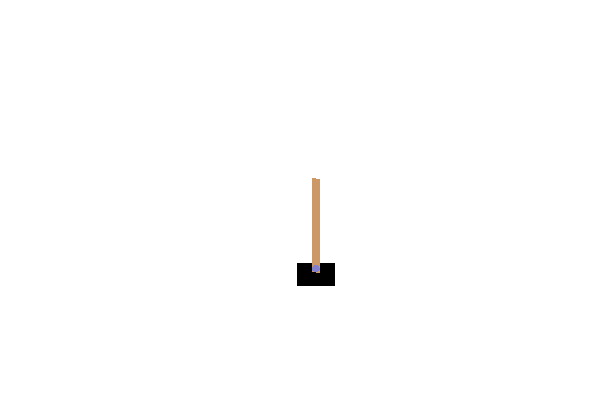
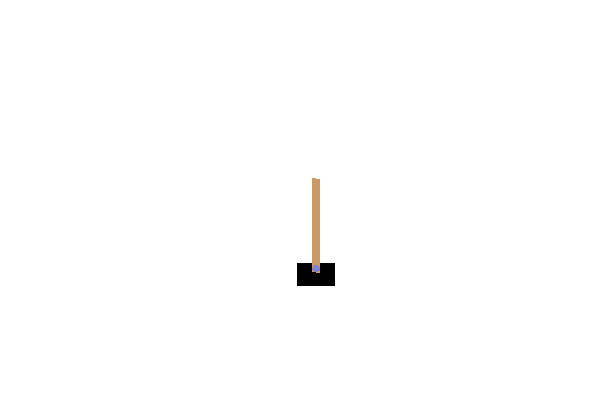
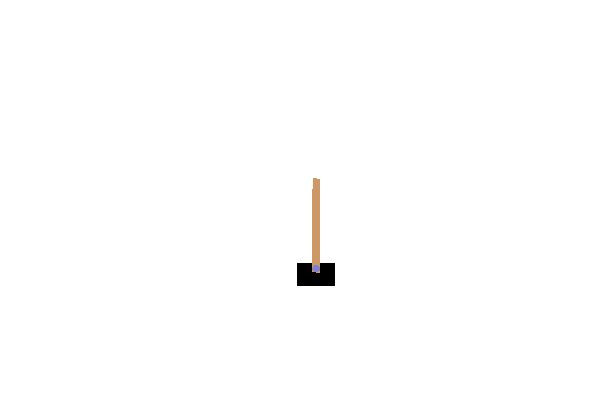
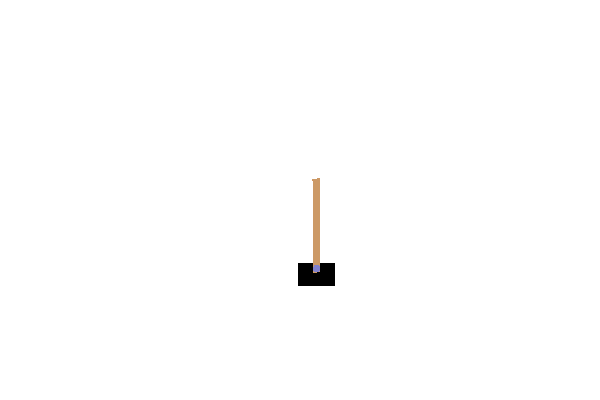
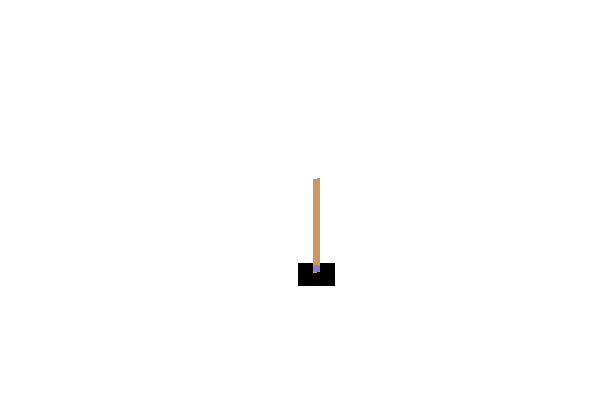
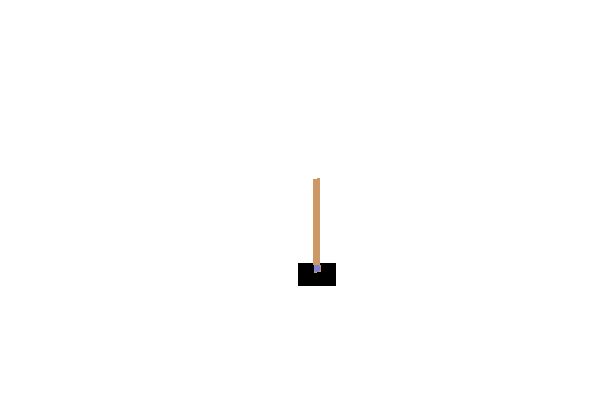
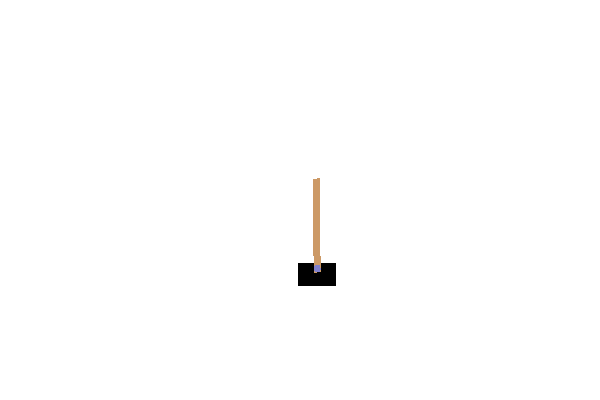
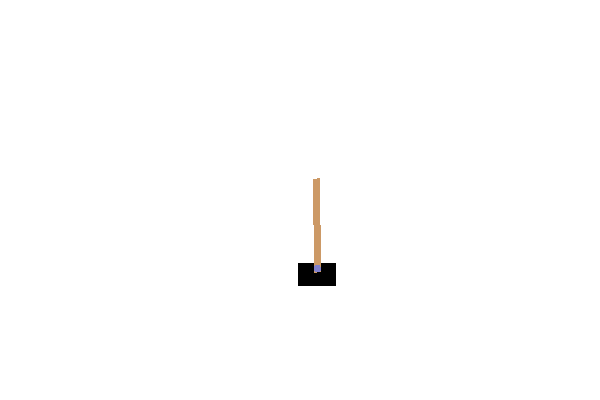
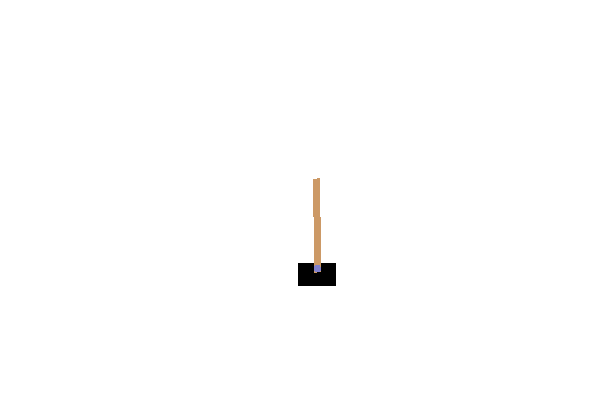
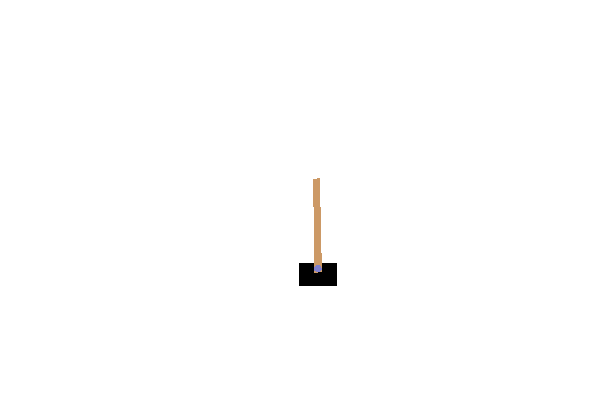
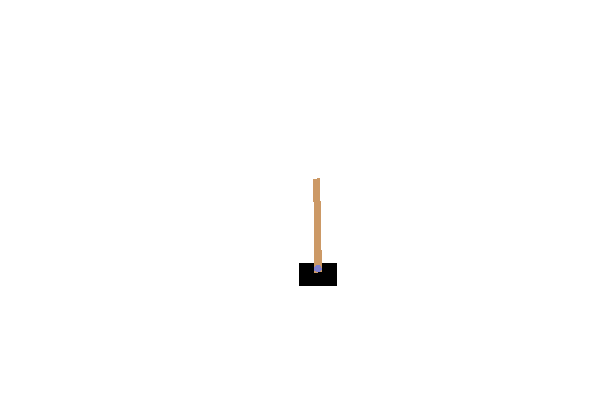
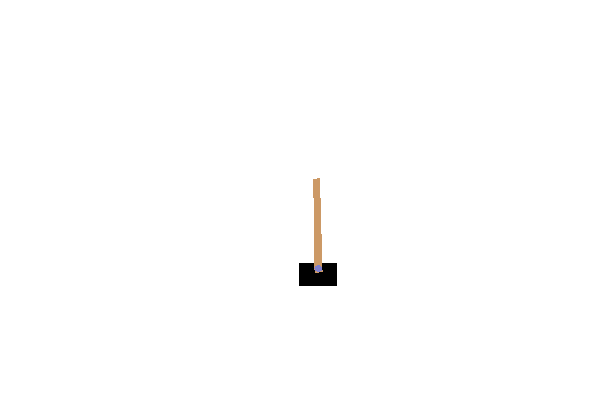
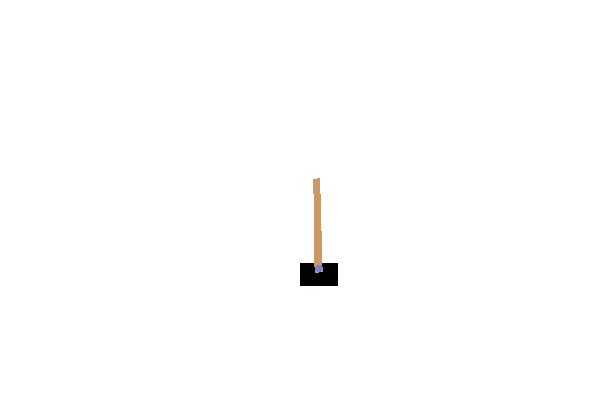
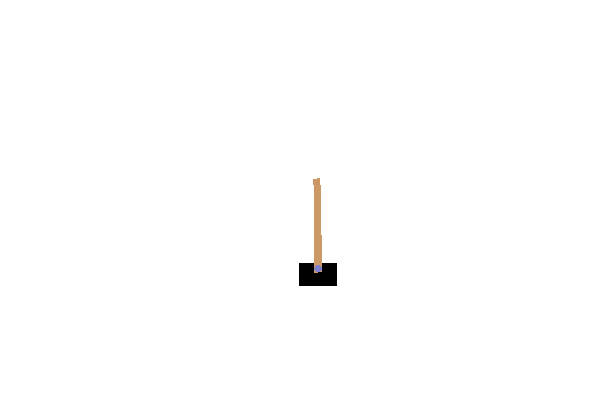
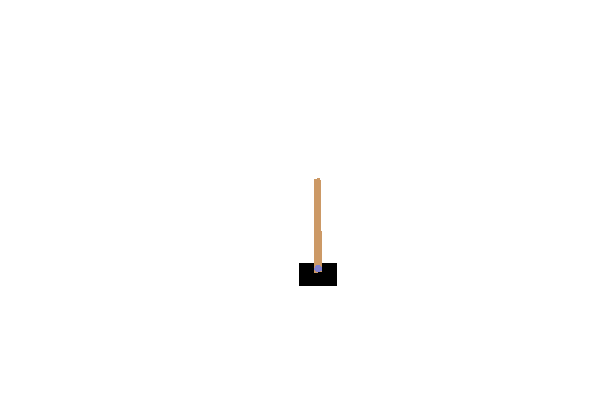
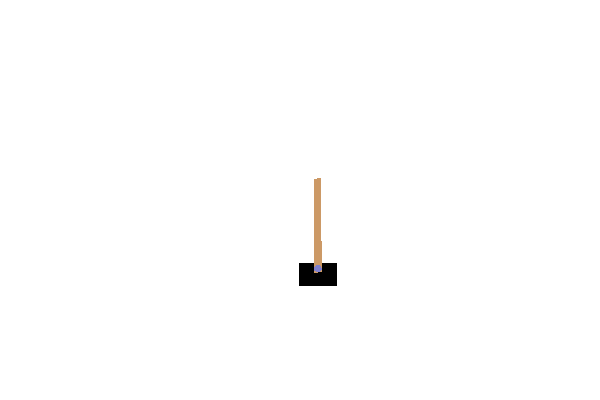
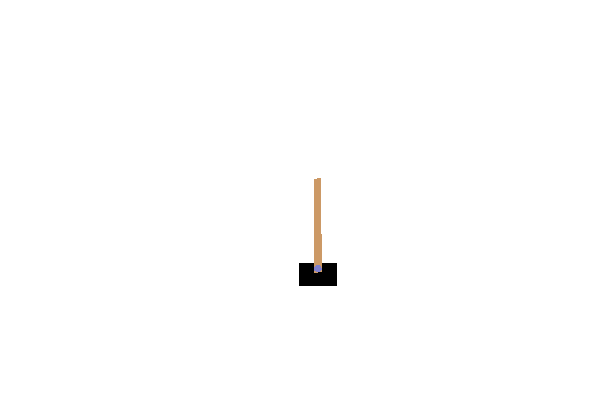
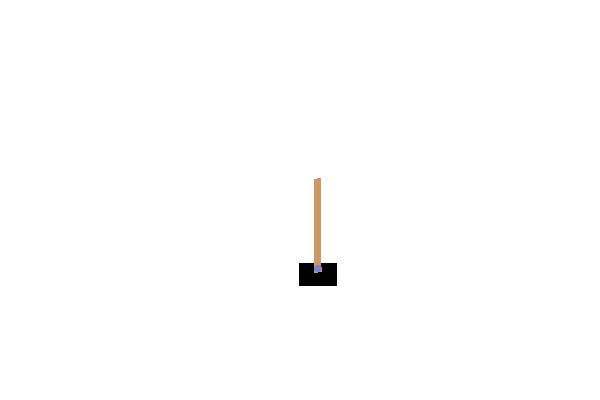
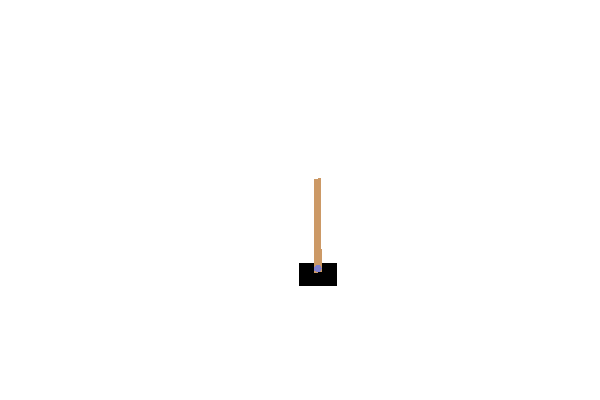
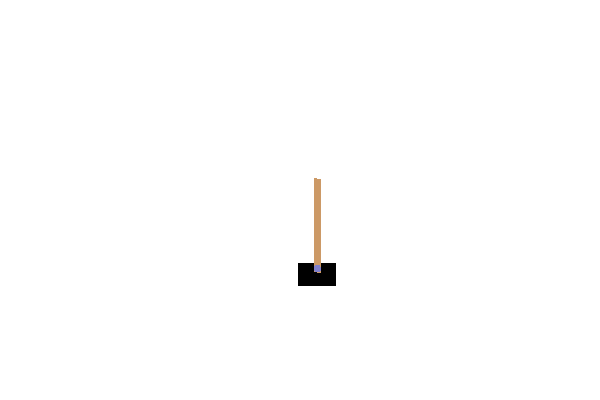
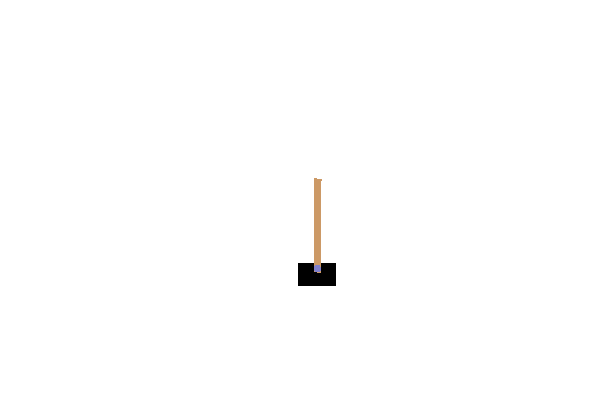
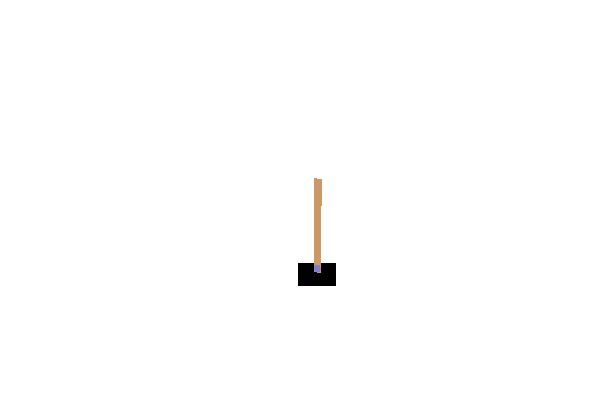
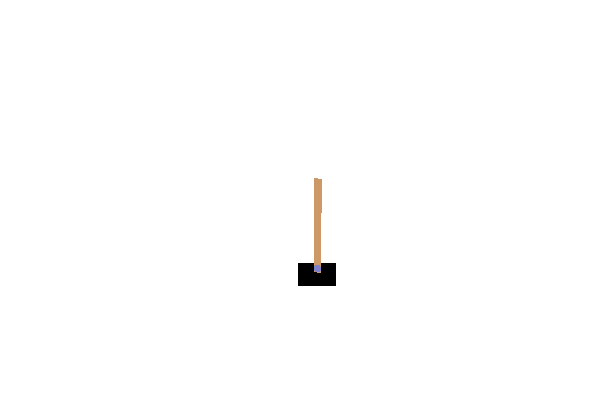
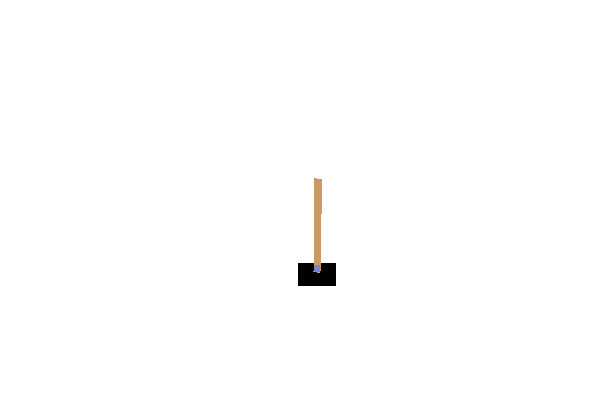
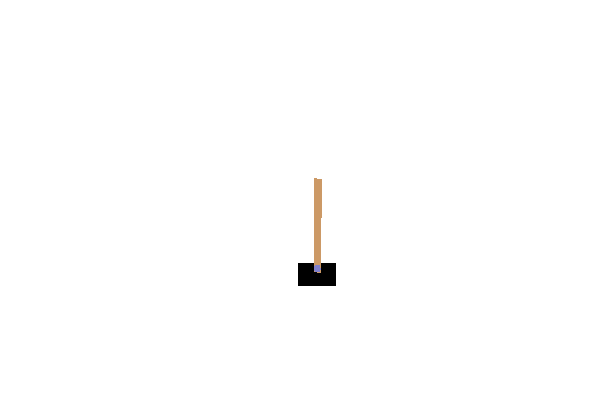
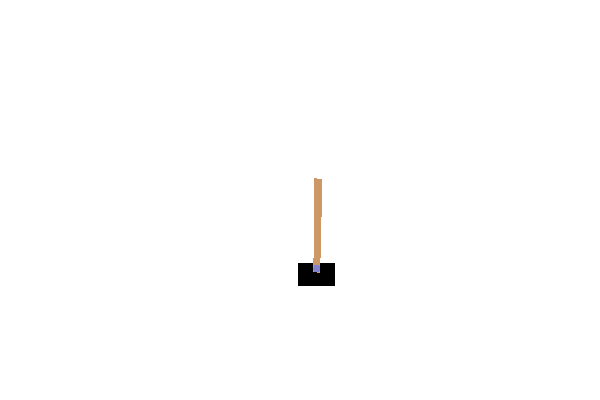
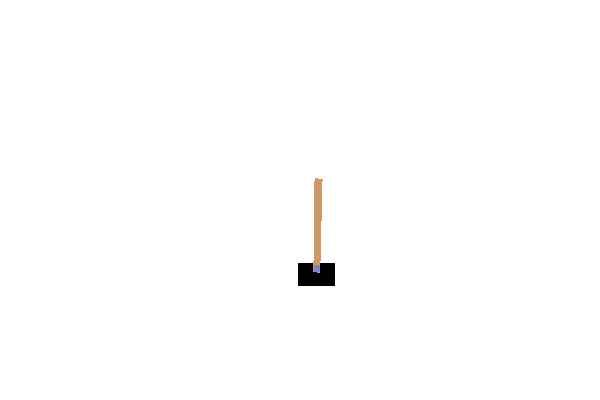
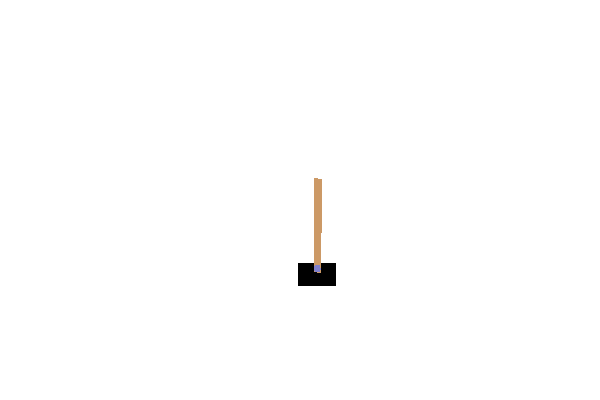
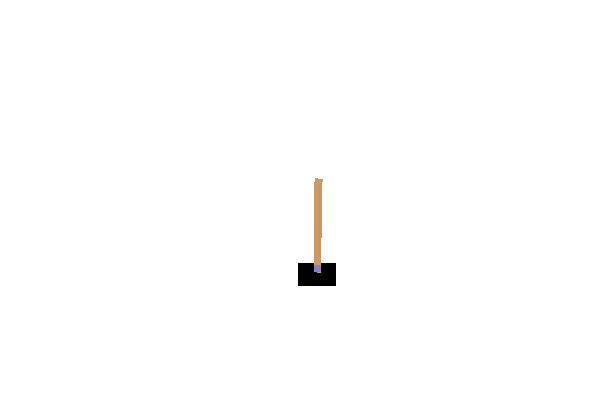
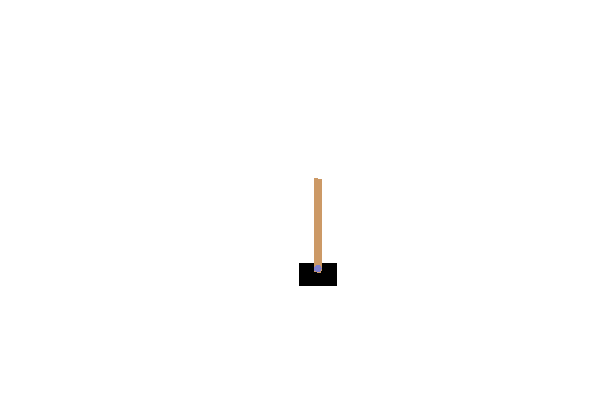
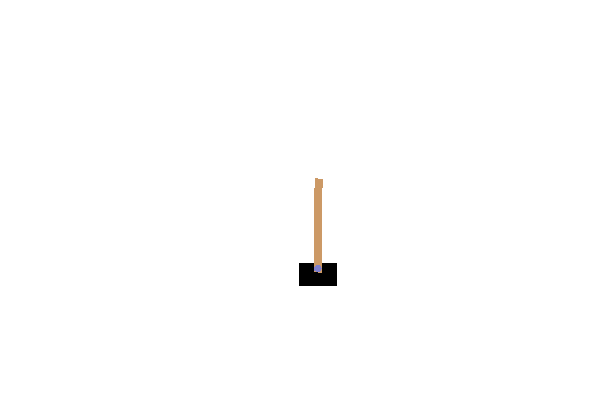
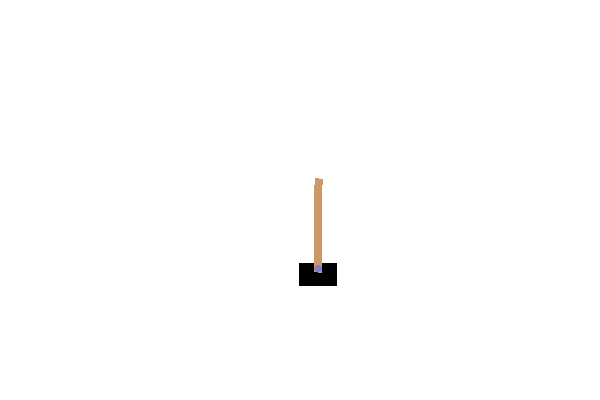
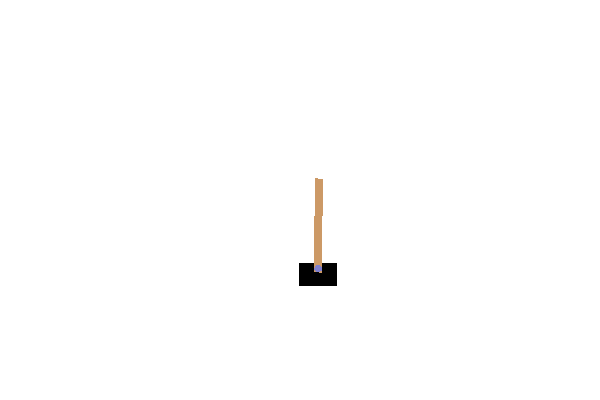
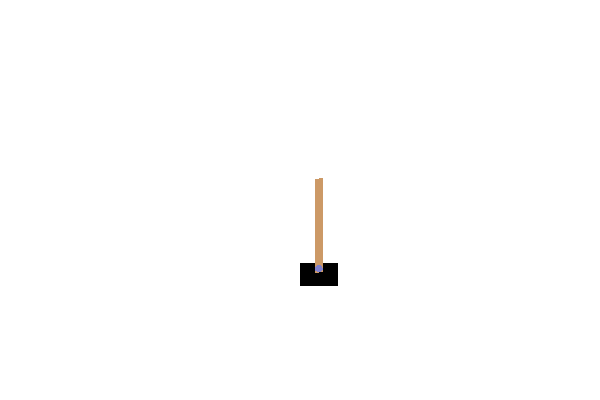
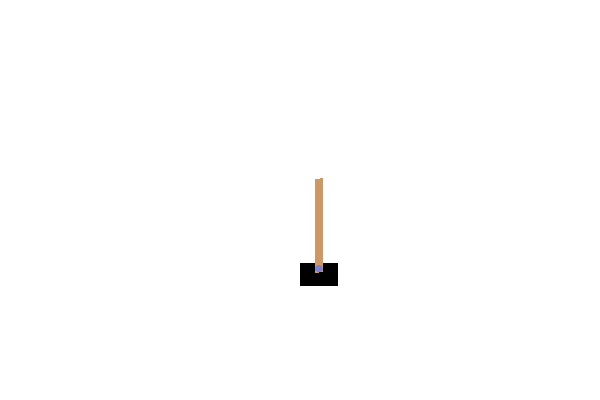
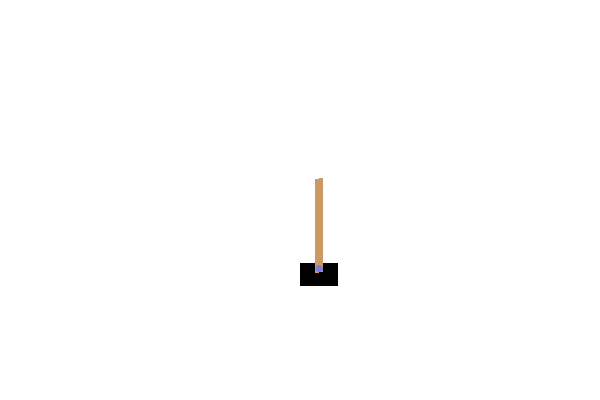
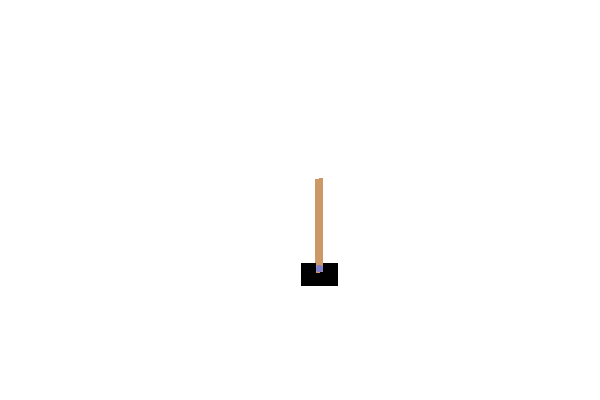
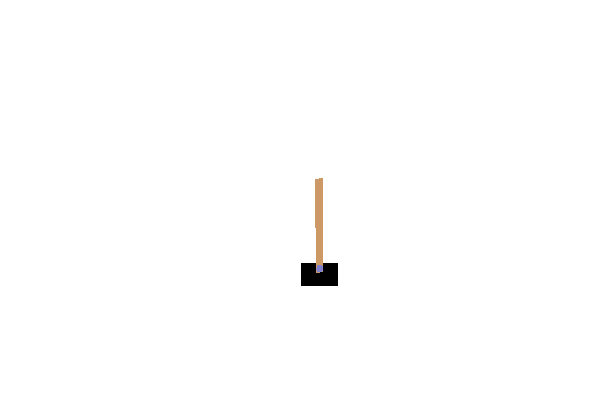
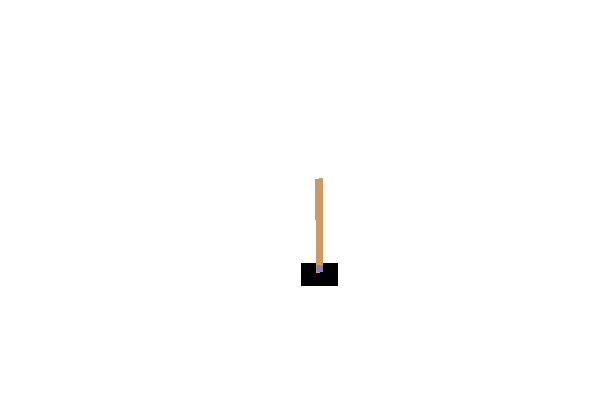
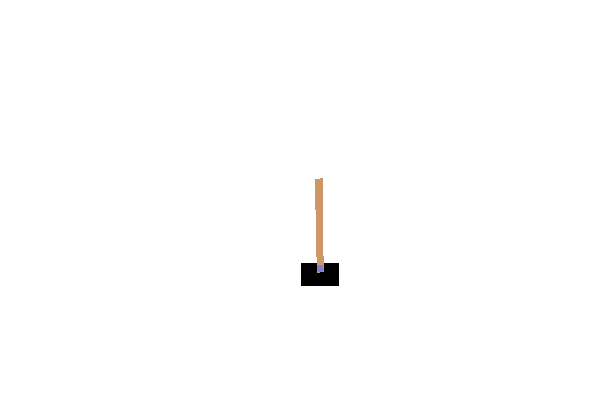
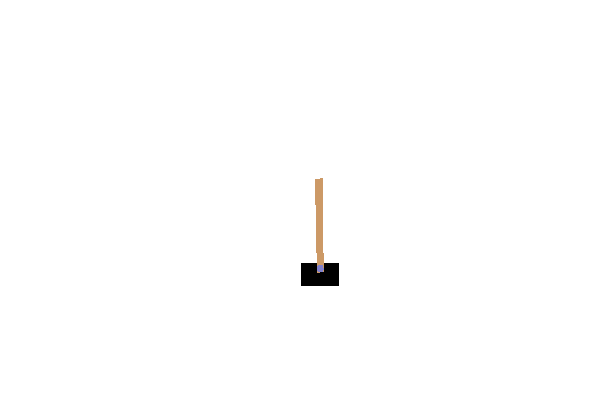
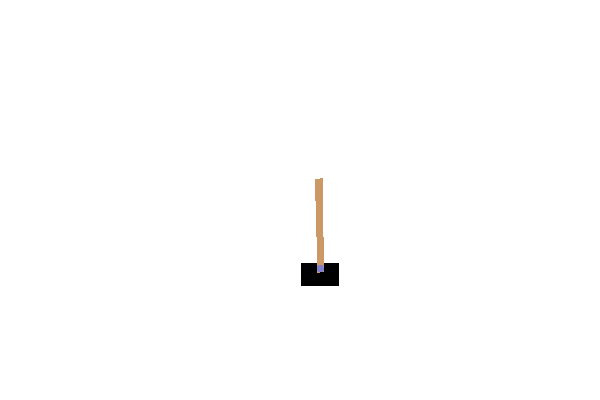
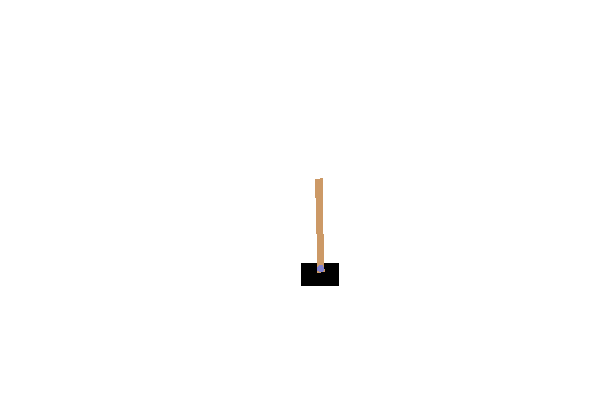
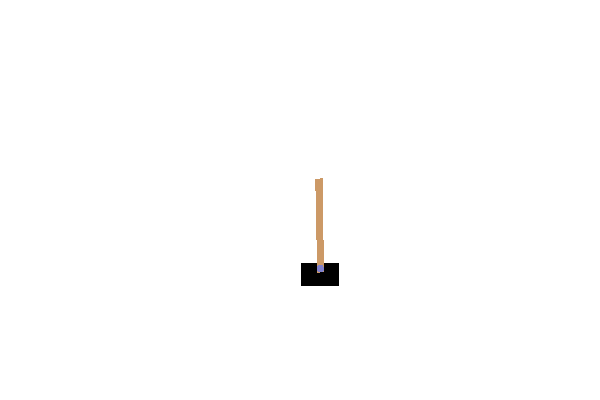
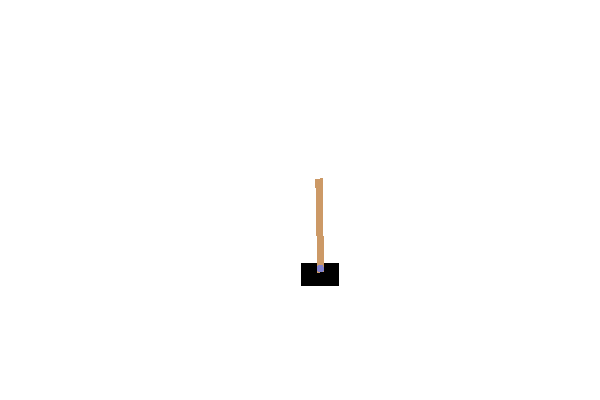
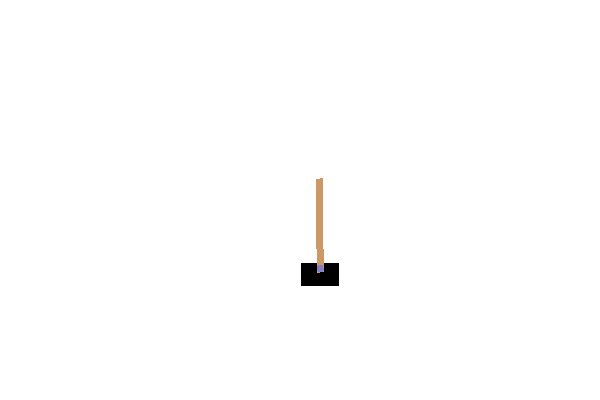
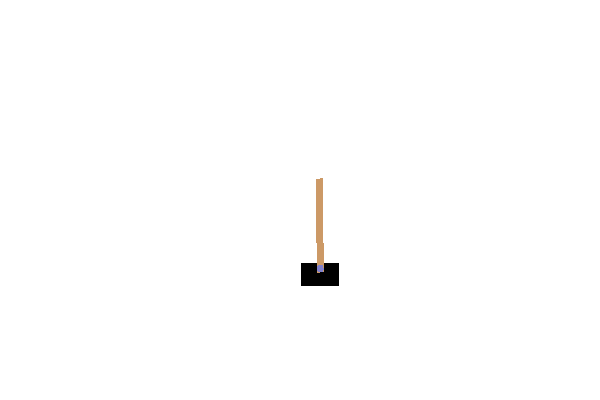
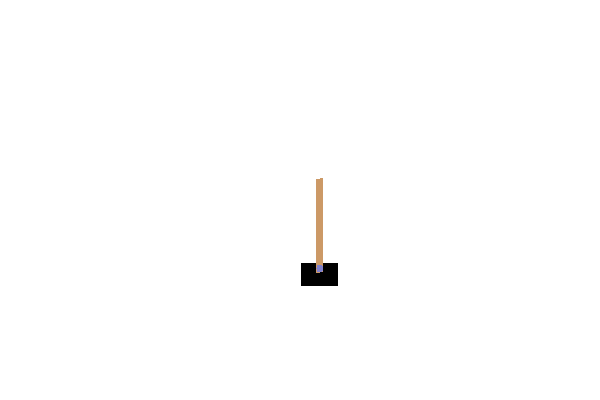
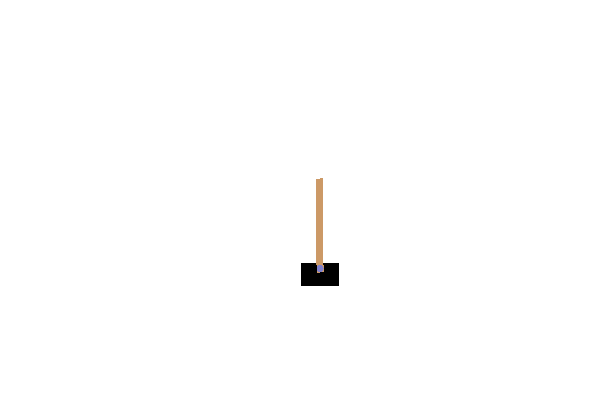
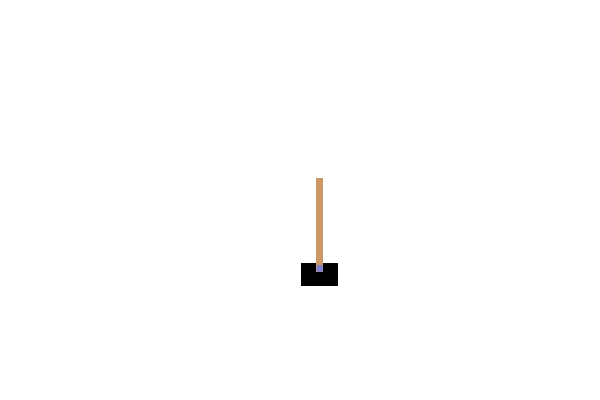
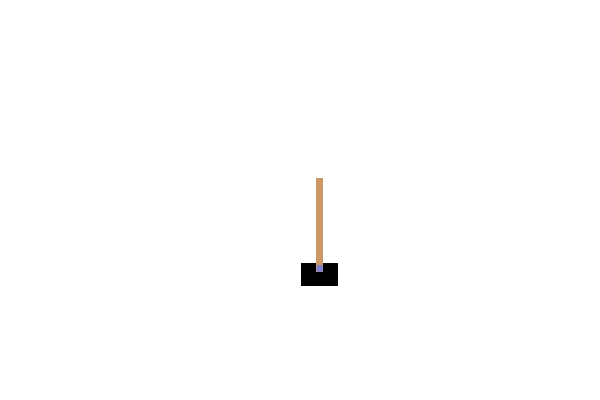
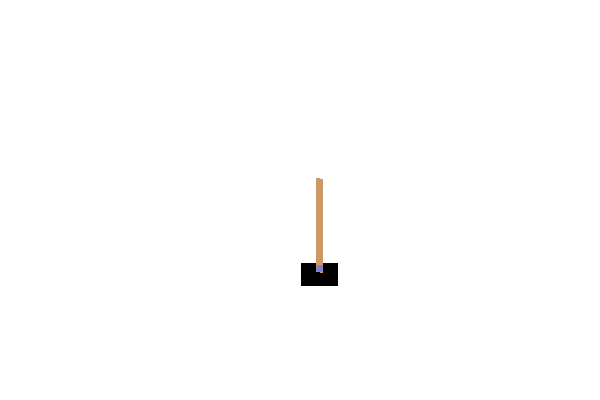
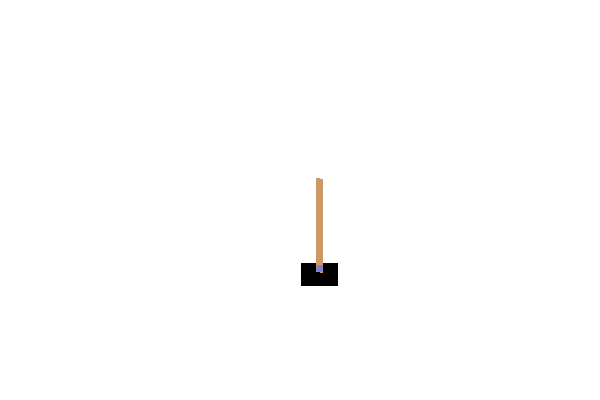
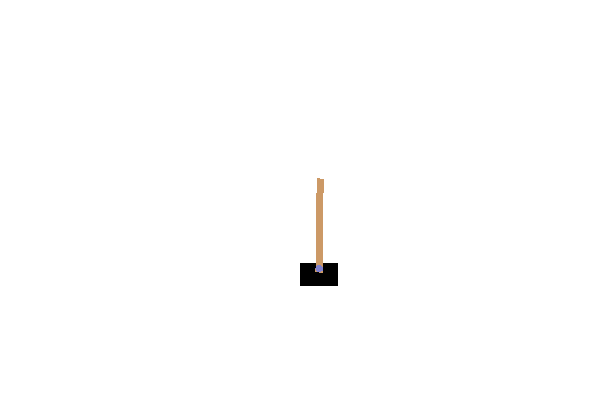
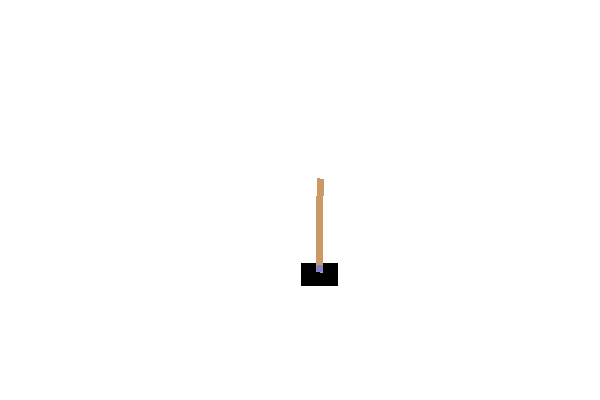
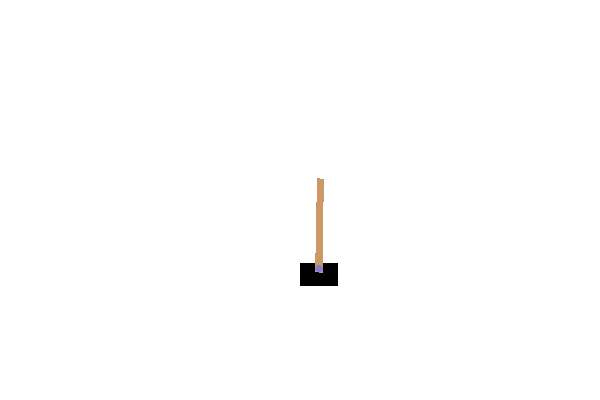
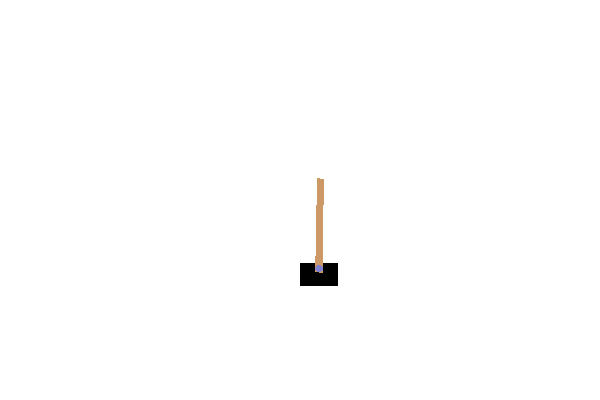

In [10]:
# main 
cartpole_env = Environment()
cartpole_env.run()
